# Load Libraries

In [1]:
%matplotlib inline
import random
import PetThermoTools as M
import re
from matplotlib.cm import get_cmap
from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import distinctipy
import PySulfSat as ss
import Thermobar as pt
import warnings


In [2]:
# check version of PetThermoTools and PySulfSat
print(M.__version__),print(ss.__version__)

0.2.1
1.0.3


(None, None)

## Modeling sulfide and sulfate saturation, using PySulfSat

In [3]:
empty_na = pd.read_excel('PetThermo_output.xlsx', index_col=0)

empty_na['pressure_bar'] = pd.to_numeric(empty_na['pressure_bar'], errors='coerce')
empty_na.dropna(subset=['pressure_bar'], inplace=True)
empty_index = pd.concat([empty_na], axis=0,ignore_index=True)

### Choose an SCSS model

In [4]:
# calculating the SCSS: sulfide concentration at sulfide saturation (ppm)
# here we use O'Neill 2021:
ONeill_MeasSulf=ss.calculate_O2021_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,Fe_FeNiCu_Sulf=0.6,Fe3Fet_Liq=empty_index['Fe3Fet_Liq'])

ONeill_MeasSulf.head() # we use column 'SCSS2_ppm'

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,index,T_C,P_bar,h,...,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique,Fe_FeNiCu_Sulf_calc
0,1728.573655,7.455052,-2.450725,-0.572569,6.315144,-0.738248,0,1425.2000,10000,-1.156315e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2,0.6
1,1716.847127,7.448245,-2.442729,-0.572729,6.340965,-0.762721,1,1420.1984,10000,-1.157538e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2,0.6
2,1705.072526,7.441363,-2.434764,-0.572883,6.366949,-0.787467,2,1415.1968,10000,-1.146360e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2,0.6
3,1693.251055,7.434406,-2.426899,-0.573029,6.393096,-0.812560,3,1410.1952,10000,-1.135284e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2,0.6
4,1681.380719,7.427371,-2.419130,-0.573169,6.419408,-0.837998,4,1405.1936,10000,-1.124451e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2,0.6


In [5]:
# Another method could be to use Li and Zhang 2022:
LiZhang22=ss.calculate_LiZhang2022_SCSS(df=empty_index, T_K=empty_index['T_C']+273.15, 
P_kbar=empty_index['pressure_bar']/1000,
                                        Fe_FeNiCu_Sulf=0.6,
                                        Fe3Fet_Liq=empty_index['Fe3Fet_Liq'], 
                                        H2O_Liq=empty_index['H2O_Liq'])
LiZhang22.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function


,SCSS_Tot,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,...,Al_cat,Fe_cat,Mn_cat,Mg_cat,Ca_cat,Na_cat,K_cat,P_cat,H_cat,Fe3_cat
0,1190.846939,0,1425.2000,10000,-1.156315e+06,286.980514,35.808094,-0.000147,-4.253934,48.962730,...,0.138235,0.059784,0.001540,0.175258,0.109207,0.035081,0.011251,0.001539,0.0,0.016047
1,1179.714971,1,1420.1984,10000,-1.157538e+06,286.264262,35.753988,-0.000132,-4.294529,48.897554,...,0.139379,0.059933,0.001556,0.172673,0.110189,0.035441,0.011369,0.001556,0.0,0.016154
2,1168.580887,2,1415.1968,10000,-1.146360e+06,282.975808,35.390578,-0.000131,-4.335365,48.832416,...,0.140530,0.060076,0.001573,0.170080,0.111173,0.035805,0.011488,0.001572,0.0,0.016260
3,1157.467316,3,1410.1952,10000,-1.135284e+06,279.725328,35.031323,-0.000130,-4.376443,48.767952,...,0.141677,0.060213,0.001589,0.167505,0.112149,0.036167,0.011607,0.001588,0.0,0.016366
4,1146.372444,4,1405.1936,10000,-1.124451e+06,276.541848,34.679722,-0.000129,-4.417766,48.704137,...,0.142819,0.060343,0.001605,0.164949,0.113118,0.036529,0.011725,0.001604,0.0,0.016471


### Choose SCAS model

In [6]:
# calculating the SCAS (ppm):
# here using the model of Zajacz and Tsay 2022:
ZT22_SCAS=ss.calculate_ZT2022_SCAS(df=empty_index, T_K=empty_index['T_C']+273.15)

ZT22_SCAS.head() # we use column 'SCAS6_ppm'

,SCAS6_ppm,index,T_C,P_bar,h,s,v,dvdp,logfO2,SiO2_Liq,...,H2O_tridymite1,CO2_tridymite1,Fe3Fet_tridymite1,h_tridymite1,mass_tridymite1,v_tridymite1,rho_tridymite1,newentry,newcolumn,unique
0,20193.291658,0,1425.2000,10000,-1.156315e+06,286.980514,35.808094,-0.000147,-4.253934,48.962730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2
1,19693.847085,1,1420.1984,10000,-1.157538e+06,286.264262,35.753988,-0.000132,-4.294529,48.897554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2
2,19210.597224,2,1415.1968,10000,-1.146360e+06,282.975808,35.390578,-0.000131,-4.335365,48.832416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2
3,18744.300338,3,1410.1952,10000,-1.135284e+06,279.725328,35.031323,-0.000130,-4.376443,48.767952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2
4,18294.046989,4,1405.1936,10000,-1.124451e+06,276.541848,34.679722,-0.000129,-4.417766,48.704137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,H2O_0.0_QFM1.2,P_10000.0_H2O_0.0_QFM1.2


### Choose a sulfur-speciation model

#### we choose the model by Jugo et al., (2010) which relies on $\Delta$QFM calculated with respect to the buffer by Frost et al., (1991) 

In [7]:
# Use Thermobar to calculate delta QFM relative to the Frost buffer

buffers=pt.convert_fo2_to_buffer(fo2=10**empty_index['logfO2'], T_K=empty_index['T_C']+273.15, 
                    P_kbar=empty_index['P_bar']/1000)
buffers.head()

empty_index['deltaQFM_Frost1991'] = buffers['DeltaQFM_Frost1991']

# calculate fraction of sulphate relative to total sulfur in the melt (s6+/Stot):
empty_index['jugo_s6st'] = 1 /(1+10**(2.1-2*empty_index['deltaQFM_Frost1991']))
empty_index['jugo_s6st']

0       0.602506
1       0.603760
2       0.605021
3       0.606288
4       0.607560
          ...   
2655    0.791866
2656    0.793862
2657    0.795861
2658    0.797864
2659    0.799871
Name: jugo_s6st, Length: 2660, dtype: float64

In [8]:
# alternative sulfur-speciaiton model by O'Neill and Mavrogenes, (2022)
# calculates s6+/Stot from log(fO2) rather than delta QFM

calcS_OM2022_Givenfo2=ss.calculate_OM2022_S6St(df=empty_index, 
                                               T_K=empty_index['T_C']+273.15,
                                               logfo2=empty_index['logfO2'])
calcS_OM2022_Givenfo2.head()

,S6St_Liq,LnCS2_calc,LnCS6_calc,LnKSO2S2,LnS6S2,deltaQFM_calc,index,T_C,P_bar,h,...,Ca_Liq_cat_frac,Al_Liq_cat_frac,Na_Liq_cat_frac,K_Liq_cat_frac,Ti_Liq_cat_frac,P_Liq_cat_frac,Mg_Number_Liq_NoFe3,Mg_Number_Liq_Fe3,Fe2Fet_Liq_calc,Fe2_Liq_cat_frac
0,0.989728,-0.741065,10.749269,-12.667803,4.568048,1.916979,0,1425.2000,10000,-1.156315e+06,...,0.109207,0.138235,0.035081,0.011251,0.004719,0.001539,0.697985,0.745641,0.762621,0.057830
1,0.989693,-0.765576,10.812843,-12.763167,4.564550,1.919957,1,1420.1984,10000,-1.157538e+06,...,0.110189,0.139379,0.035441,0.011369,0.004765,0.001556,0.694129,0.742336,0.760842,0.057890
2,0.989659,-0.790361,10.876822,-12.859103,4.561195,1.922953,2,1415.1968,10000,-1.146360e+06,...,0.111173,0.140530,0.035805,0.011488,0.004811,0.001572,0.690205,0.738969,0.759046,0.057943
3,0.989625,-0.815493,10.941125,-12.955615,4.557969,1.925967,3,1410.1952,10000,-1.135284e+06,...,0.112149,0.141677,0.036167,0.011607,0.004858,0.001588,0.686252,0.735575,0.757247,0.057989
4,0.989594,-0.840971,11.005753,-13.052707,4.554868,1.928998,4,1405.1936,10000,-1.124451e+06,...,0.113118,0.142819,0.036529,0.011725,0.004904,0.001604,0.682267,0.732151,0.755445,0.058029


## Modelling Degassing of Cl and S

In [9]:
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)

# create empty dataframe
syst_mass = pd.DataFrame()

for i in empty_index.unique.unique():
    
    dfuniq = empty_index[empty_index.unique == i]
    
    # mass of initial melt (g)
    dfuniq['i_M_melt'] = dfuniq['mass_Liq'].iloc[0]
    
    # Melt Fraction at step i
    dfuniq['melt_f'] = dfuniq['mass_Liq'].div(dfuniq['i_M_melt'])
    
    # Mass of cumulative fluid (inc first step)
    dfuniq['cum_mass_fluid']=dfuniq['mass_fluid1'].cumsum()
    
    # Mass of cumulative fluid (minus first step)
    dfuniq['cum_mass_fluid_notstep1']=dfuniq['cum_mass_fluid']-dfuniq['mass_fluid1'].iloc[0]
    
    #PW fluid exsolved each step
    dfuniq['M_fluid_PW_H2O']=(dfuniq['H2O_fluid1']/100)*(dfuniq['mass_fluid1'])
    # Cumulative across all steps
    dfuniq['fluid_cum_sum_H2O']=dfuniq['M_fluid_PW_H2O'].cumsum()
    dfuniq['fluid_cum_sum_H2O'].replace([np.inf, -np.inf], 0, inplace=True)
    dfuniq['fluid_cum_sum_H2O'].fillna(0, inplace=True)
    
    # mass of first/initial fluid (g)
    dfuniq['i_M_fluid'] = dfuniq['fluid_cum_sum_H2O'].iloc[0]
    
    # mass of solid crystals (g) at step i 
    dfuniq['M_solid'] = dfuniq['i_M_melt'] - dfuniq['mass_Liq']-dfuniq['fluid_cum_sum_H2O']
    
    # mass of solid crystals (g) at step i 
    dfuniq['i_M_solid'] = dfuniq['M_solid'].iloc[0]
    
    #append to dataframe
    syst_mass = pd.concat([syst_mass,dfuniq],ignore_index=True)


In [10]:
# Add SCSS, SCAS and S-speciation calculations to working dataframe:

syst_mass['DeltaQFM_OMbuff'] = calcS_OM2022_Givenfo2['deltaQFM_calc'].values
syst_mass['DeltaQFM_JUGO'] = buffers['DeltaQFM_Frost1991']
syst_mass['DeltaQFM_frostbuff'] = buffers['DeltaQFM_Frost1991'].values

syst_mass['SCSS_liz'] = LiZhang22['SCSS_Tot'].values

syst_mass['SCSS_OM21'] = ONeill_MeasSulf['SCSS2_ppm'].values
syst_mass['SCAS']=ZT22_SCAS['SCAS6_ppm'].values

syst_mass['S6St_OMfO2'] = calcS_OM2022_Givenfo2['S6St_Liq'].values
syst_mass['jugo_s6st'] = empty_index['jugo_s6st']

In [11]:
syst_mass[['jugo_s6st','S6St_OMfO2','SCAS','SCSS_OM21','DeltaQFM_frostbuff']].head()

,jugo_s6st,S6St_OMfO2,SCAS,SCSS_OM21,DeltaQFM_frostbuff
0,0.602506,0.989728,20193.291658,1728.573655,1.140315
1,0.603760,0.989693,19693.847085,1716.847127,1.141453
2,0.605021,0.989659,19210.597224,1705.072526,1.142598
3,0.606288,0.989625,18744.300338,1693.251055,1.143750
4,0.607560,0.989594,18294.046989,1681.380719,1.144908


### Setting S fluid-melt partition coefficients

In [12]:
DS = np.empty(len(syst_mass), dtype=float) 
DS.dtype

dtype('float64')

In [13]:
syst_mass['pressure_bar_str'] = syst_mass.pressure_bar.astype(str)
syst_mass['pressure_bar_str']

0       10000
1       10000
2       10000
3       10000
4       10000
        ...  
2655      500
2656      500
2657      500
2658      500
2659      500
Name: pressure_bar_str, Length: 2660, dtype: object

In [14]:
# We model DS_fluid-melt using estimates from Keppler (2010) and Masotta et al., (2016) 
# for an oxidised melt.
# DS_fluid-melt ranges from 1 to 200 between SiO2 contents of 45 to 80 wt%

DS_10000 =  {45:1, 50:1, 55:2, 60:5, 65:10, 70:15, 75:40, 80:70} 

DS_8000 =  {45:1, 50:1, 55:2, 60:5, 65:10, 70:15, 75:40, 80:70} 

DS_4000 =  {45:1, 50:1, 55:2, 60:5, 65:10, 70:15, 75:40, 80:70}

DS_2000 =  {45:1, 50:1, 55:2, 60:5, 65:10, 70:15, 75:40, 80:70}

DS_1000 =  {45:1, 50:1, 55:3, 60:8, 65:15, 70:30, 75:60, 80:90}

DS_500 =  {45:10, 50:10, 55:20, 60:30, 65:50, 70:70, 75:100, 80:200}

DS_dict = {'10000':DS_10000,'8000':DS_8000,'4000':DS_4000,'2000':DS_2000,'1000':DS_1000, '500':DS_500}


10000: 0.00x + 1.00 for 45 <= x <= 50
10000: 0.20x + -9.00 for 50 <= x <= 55
10000: 0.60x + -31.00 for 55 <= x <= 60
10000: 1.00x + -55.00 for 60 <= x <= 65
10000: 1.00x + -55.00 for 65 <= x <= 70
10000: 5.00x + -335.00 for 70 <= x <= 75
10000: 6.00x + -410.00 for 75 <= x <= 80
8000: 0.00x + 1.00 for 45 <= x <= 50
8000: 0.20x + -9.00 for 50 <= x <= 55
8000: 0.60x + -31.00 for 55 <= x <= 60
8000: 1.00x + -55.00 for 60 <= x <= 65
8000: 1.00x + -55.00 for 65 <= x <= 70
8000: 5.00x + -335.00 for 70 <= x <= 75
8000: 6.00x + -410.00 for 75 <= x <= 80
4000: 0.00x + 1.00 for 45 <= x <= 50
4000: 0.20x + -9.00 for 50 <= x <= 55
4000: 0.60x + -31.00 for 55 <= x <= 60
4000: 1.00x + -55.00 for 60 <= x <= 65
4000: 1.00x + -55.00 for 65 <= x <= 70
4000: 5.00x + -335.00 for 70 <= x <= 75
4000: 6.00x + -410.00 for 75 <= x <= 80
2000: 0.00x + 1.00 for 45 <= x <= 50
2000: 0.20x + -9.00 for 50 <= x <= 55
2000: 0.60x + -31.00 for 55 <= x <= 60
2000: 1.00x + -55.00 for 60 <= x <= 65
2000: 1.00x + -55.00 for

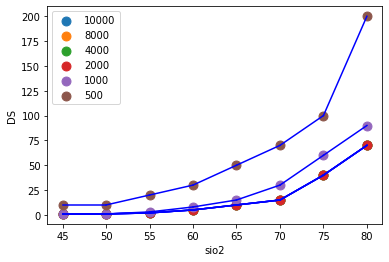

     pressure_bar_str    DS_calc   SiO2_Liq
0               10000   1.000000  48.962730
1               10000   1.000000  48.897554
2               10000   1.000000  48.832416
3               10000   1.000000  48.767952
4               10000   1.000000  48.704137
...               ...        ...        ...
2655              500  74.435863  70.739311
2656              500  75.456152  70.909359
2657              500  76.442954  71.073826
2658              500  77.398586  71.233098
2659              500  78.326322  71.387720

[2660 rows x 3 columns]


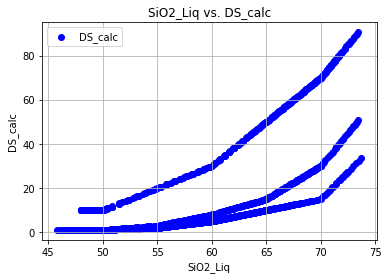

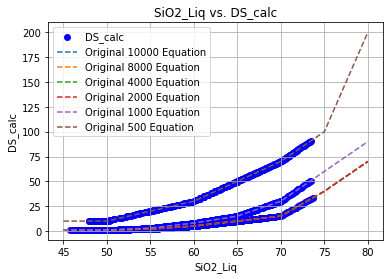

In [15]:
# Plot and print the equation for lines connecting points
for name, data in DS_dict.items():
    x = list(data.keys())
    y = list(data.values())


    # Plot the data points
    plt.scatter(x, y, label=name,  s=80)

    # Calculate the equations of the lines connecting points
    equations = []
    for i in range(len(x) - 1):
        x1, y1 = x[i], y[i]
        x2, y2 = x[i + 1], y[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        equations.append(f"{slope:.2f}x + {intercept:.2f} for {x1} <= x <= {x2}")
    
    # Print the equations of the lines
    for eq in equations:
        print(f"{name}: {eq}")

    # Plot the lines connecting points
    for i in range(len(x) - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], linestyle='-', color='blue')

# Add labels and legend
plt.xlabel('sio2')
plt.ylabel('DS')
plt.legend()
plt.show()

# Sample DataFrame 'systmass' with 'SiO2_Liq' and 'pressure_bar_str' columns
# Replace this with your actual DataFrame
syst_mass[['SiO2_Liq', 'pressure_bar_str']]

# Create a list to store calculated values
calculated_values = []

# Function to calculate DS_calc for each row
def calculate_DS_calc(row):
    SiO2_Liq = row['SiO2_Liq']
    pressure_bar_str = row['pressure_bar_str']

    # Check if pressure_bar_str exists in DS_dict
    if pressure_bar_str in DS_dict:
        equations = DS_dict[pressure_bar_str]

        # Extract x values from the equation
        x_values = list(equations.keys())

        # Find the closest lower and upper x values in the equation
        closest_lower_x = max([x for x in x_values if x <= SiO2_Liq], default=None)
        closest_upper_x = min([x for x in x_values if x >= SiO2_Liq], default=None)

        if closest_lower_x is not None and closest_upper_x is not None:
            slope = (equations[closest_upper_x] - equations[closest_lower_x]) / (closest_upper_x - closest_lower_x)
            intercept = equations[closest_lower_x] - slope * closest_lower_x
            DS_calc = slope * SiO2_Liq + intercept
            return DS_calc

    return None



# Calculate DS_calc for each row and store it in the list
for index, row in syst_mass.iterrows():
    calculated_value = calculate_DS_calc(row)
    calculated_values.append(calculated_value)

# Add the calculated values to the DataFrame
syst_mass['DS_calc'] = calculated_values

# Print the updated DataFrame with DS_calc values
print(syst_mass[['pressure_bar_str','DS_calc', 'SiO2_Liq']])


# Assuming syst_mass is your DataFrame with SiO2_Liq and DS_calc columns
# Replace with your actual DataFrame name if different
x = syst_mass['SiO2_Liq']
y = syst_mass['DS_calc']

plt.scatter(x, y, label='DS_calc', color='blue')
plt.xlabel('SiO2_Liq')
plt.ylabel('DS_calc')
plt.title('SiO2_Liq vs. DS_calc')
plt.legend()
plt.grid(True)
plt.show()


# Plot the scatter points
plt.scatter(x, y, label='DS_calc', color='blue')

# Overlay the original equations as lines
for name, data in DS_dict.items():
    x_values = list(data.keys())
    y_values = list(data.values())
    plt.plot(x_values, y_values, label=f'Original {name} Equation', linestyle='--')

plt.xlabel('SiO2_Liq')
plt.ylabel('DS_calc')
plt.title('SiO2_Liq vs. DS_calc')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Append S fluid-melt partition coeffcients to the master dataframe
syst_mass['DS_fm'] = syst_mass['DS_calc']

### Setting Cl fluid-melt partition coefficients

In [17]:
DCl = np.empty(len(syst_mass), dtype=float)

In [18]:
# We model DCl_fluid-melt using estimates from Tattitch et al., (2021) 
# DCl_fluid-melt ranges from 3 to 65 between SiO2 contents of 45 to 80 wt%

DCl_10000 =  {45:3, 50:4, 55:5, 60:8, 65:15, 70:25, 75:40, 80:65}

DCl_8000 =  {45:3, 50:4, 55:5, 60:8, 65:15, 70:25, 75:40, 80:65}

DCl_4000 =  {45:3, 50:4, 55:5, 60:8, 65:15, 70:25, 75:40, 80:65}

DCl_2000 =  {45:1, 50:2, 55:3, 60:5, 65:10, 70:15, 75:25, 80:45}

DCl_1000 =  {45:1, 50:1, 55:2, 60:3, 65:5, 70:8, 75:10, 80:18}

DCl_500 =  {45:1, 50:1, 55:1, 60:1.5, 65:2, 70:2.5, 75:4, 80:6}

DCl_dict = {'10000':DCl_10000,'8000':DCl_8000,'4000':DCl_4000,'2000':DCl_2000,'1000':DCl_1000, '500':DCl_500 }


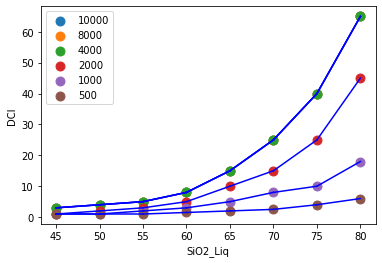

     pressure_bar_str  DCl_calc   SiO2_Liq
0               10000  3.792546  48.962730
1               10000  3.779511  48.897554
2               10000  3.766483  48.832416
3               10000  3.753590  48.767952
4               10000  3.740827  48.704137
...               ...       ...        ...
2655              500  2.721793  70.739311
2656              500  2.772808  70.909359
2657              500  2.822148  71.073826
2658              500  2.869929  71.233098
2659              500  2.916316  71.387720

[2660 rows x 3 columns]


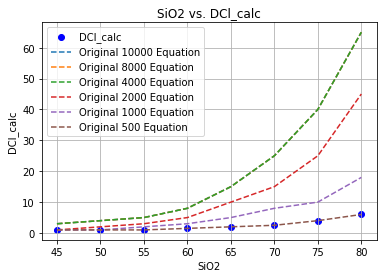

In [19]:
for name, data in DCl_dict.items():
    x = list(data.keys())
    y = list(data.values())

    # Plot the data points
    plt.scatter(x, y, label=name,s=80)

    # Calculate the equations of the lines connecting points
    equations = []
    for i in range(len(x) - 1):
        x1, y1 = x[i], y[i]
        x2, y2 = x[i + 1], y[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        equations.append(f"{slope:.2f}x + {intercept:.2f} for {x1} <= x <= {x2}")
    
    # Print the equations of the lines if you wish
    #for eq in equations:
    #    print(f"{name}: {eq}")

    # Plot the lines connecting points
    for i in range(len(x) - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], linestyle='-', color='blue')

# Add labels and legend
plt.xlabel('SiO2_Liq')
plt.ylabel('DCl')
plt.legend()
plt.show()

# Sample DataFrame 'systmass' with 'SiO2_Liq' and 'pressure_bar_str' columns
# Replace this with your actual DataFrame
syst_mass[['SiO2_Liq', 'pressure_bar_str']]

# Create a list to store calculated values
calculated_values = []


# Function to calculate DCl_calc for each row
def calculate_DCl_calc(row):
    melt_f = row['SiO2_Liq']
    pressure_bar_str = row['pressure_bar_str']

    # Check if pressure_bar_str exists in DCl_dict
    if pressure_bar_str in DCl_dict:
        equations = DCl_dict[pressure_bar_str]

        # Extract x values from the equation
        x_values = list(equations.keys())

        # Find the closest lower and upper x values in the equation
        closest_lower_x = max([x for x in x_values if x <= melt_f], default=None)
        closest_upper_x = min([x for x in x_values if x >= melt_f], default=None)

        if closest_lower_x is not None and closest_upper_x is not None:
            if closest_lower_x == closest_upper_x:
                # Handle the case where closest_upper_x and closest_lower_x are the same
                DCl_calc = equations[closest_lower_x]  # Use the value directly
            else:
                slope = (equations[closest_upper_x] - equations[closest_lower_x]) / (closest_upper_x - closest_lower_x)
                intercept = equations[closest_lower_x] - slope * closest_lower_x
                DCl_calc = slope * melt_f + intercept
            return DCl_calc

    return None



# Calculate DS_calc for each row and store it in the list
for index, row in syst_mass.iterrows():
    calculated_value = calculate_DCl_calc(row)
    calculated_values.append(calculated_value)

# Add the calculated values to the DataFrame
syst_mass['DCl_calc'] = calculated_values

# Print the updated DataFrame with DS_calc values
print(syst_mass[['pressure_bar_str','DCl_calc', 'SiO2_Liq']])


# Plot the scatter points
plt.scatter(x, y, label='DCl_calc', color='blue')

# Overlay the original equations as lines
for name, data in DCl_dict.items():
    x_values = list(data.keys())
    y_values = list(data.values())
    plt.plot(x_values, y_values, label=f'Original {name} Equation', linestyle='--')

plt.xlabel('SiO2')
plt.ylabel('DCl_calc')
plt.title('SiO2 vs. DCl_calc')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Append DCl_fluid-melt to the working dataframe
syst_mass['DCl_fm'] = syst_mass['DCl_calc']

### Truncate melt fractions to 1 dp

In [21]:
import math
def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [22]:
# create extra column for melt fraction truncated to 1 dp
syst_mass['meltf_1dp1'] = 0 
meltf_1dp = []

for i in range(len(syst_mass)):
    x = syst_mass['melt_f'][i]
    syst_mass['meltf_1dp1'] = truncate(x, decimals=1)
    meltf_1dp.append(syst_mass['meltf_1dp1'].loc[i])
syst_mass['meltf_1dp1'] = meltf_1dp

In [23]:
## INPUT INITIAL S and Cl CONCENTRATIONS HERE (PPM)
input_dict = {'S':1000, 'Cl':1000} 


for key,val in input_dict.items():
    print(key,val)
    # initial concentration (ppm) of S and Cl in system
    syst_mass['initial_'+ key] = val
    
    # bulk concentration (ppm) of S and Cl in system 
    syst_mass['bulk_'+ key +'_ppm'] = syst_mass['initial_'+ key] / syst_mass['melt_f']
    
    # mass (g) of S and Cl in melt + fluid 
    syst_mass['M_bulk_'+ key] = (syst_mass['fluid_cum_sum_H2O'] + syst_mass['mass_Liq'])*(syst_mass['bulk_'+ key +'_ppm']/10**6) 
      
    # G; mass fraction of S and Cl in the melt relative to the fluid
    syst_mass['G'] = syst_mass['mass_Liq'].div(syst_mass['fluid_cum_sum_H2O'])
    syst_mass['G'].replace([np.inf, -np.inf], 0, inplace=True)

S 1000
Cl 1000


In [24]:
# export for resorption calculation 
# this will be used in 'Sulfide Resorption Modelling.ipynb'
syst_mass.to_csv('before_degassing_sulfsat.csv')

In [25]:
# Calculations for modelling S and Cl degassing:

Kd_dict = {'S':'DS_fm','Cl':'DCl_fm'} 
for key,val in Kd_dict.items():
    
    syst_mass[key] = syst_mass[val]  
for key,val in Kd_dict.items():
    
    # fluid-melt partition coefficient of S or Cl divided by respected G factor
    syst_mass[key +'_D/G'] = syst_mass[val].div(syst_mass['G'])
    syst_mass[key +'_D/G'].replace([np.inf, -np.inf], 0, inplace=True) # IMPORTANT FOR DRY CASE 

for key,val in Kd_dict.items(): 
    # mass (g) of S and Cl partitioning into fluid
    syst_mass['M_fluid_'+key] = syst_mass['M_bulk_'+ key]*(syst_mass[key +'_D/G'] / (syst_mass[key +'_D/G']+1))
    syst_mass['M_fluid_'+key].replace([np.inf, -np.inf], 0, inplace=True) 
    
for key,val in Kd_dict.items(): 
    # mass (g) of S and Cl in melt following fluid exsolution
    syst_mass['M_melt_'+key] = syst_mass['M_bulk_'+ key] - syst_mass['M_fluid_'+key]

for key,val in Kd_dict.items():    
    # check bulk mass (g) of S and Cl in fluid and melt
    syst_mass['M_bulk_'+key+'_check'] = (syst_mass['M_melt_'+key]+syst_mass['M_fluid_'+key]).div(syst_mass['M_bulk_'+ key])

for key,val in Kd_dict.items():
    # concentration (ppm) of S and Cl in fluid
    syst_mass['fluid_'+key+'_ppm'] = 1000000 * syst_mass['M_fluid_'+key].div(syst_mass['fluid_cum_sum_H2O'])
    
    syst_mass['fluid_'+key+'_ppm'] = syst_mass['fluid_'+key+'_ppm'].fillna(0)

for key,val in Kd_dict.items():    
    # concentration (ppm) of S and Cl in melt following fluid exsolution
    syst_mass['melt_'+key+'_ppm'] = 1000000 * syst_mass['M_melt_'+key].div(syst_mass['mass_Liq'])
    syst_mass['melt_'+key+'_ppm'] = syst_mass['melt_'+key+'_ppm'].fillna(0)

for key,val in Kd_dict.items():    
    # Cl molinity of fluid (moles/kg)
    syst_mass['mCl_fluid'] = 1000 * (syst_mass['M_fluid_Cl']/35)/syst_mass['fluid_cum_sum_H2O']
    
for key,val in Kd_dict.items():    
    # mole fraction Cl in fluid
    syst_mass['molXCl_fluid'] = 100 * (syst_mass['M_fluid_Cl']/35).div((syst_mass['M_fluid_Cl']/35) + (syst_mass['fluid_cum_sum_H2O']/18))
    
for key,val in Kd_dict.items():
    # NaCl (wt%) in fluid
    syst_mass['NaCl_fluid'] = 100*(((syst_mass['M_fluid_Cl']/35)*22.99)+syst_mass['M_fluid_Cl'])/syst_mass['fluid_cum_sum_H2O']
    

## Modelling Degassing of chalcophile elements

In [26]:
## INPUT INITIAL CHALCOPHILE CONCENTRATIONS HERE (PPM)
input_metal_dict = {'Cu':75,'Ag':0.03,'Au':0.0033,'Se':0.14,'Re':0.001,'Te':0.5}

# calculating chalcophile fluid-melt partition coeffcients using published experimental data
# and parameterisations (see manuscript and SM1 references)


# Initialize all columns to 0
syst_mass['DCu_fm'] = 0
syst_mass['DAg_fm'] = 0
syst_mass['DAu_fm'] = 0
syst_mass['DSe_fm'] = 0
syst_mass['DTe_fm'] = 0
syst_mass['DRe_fm'] = 0

# Define a custom function to apply the conditions row-wise
def assign_values(row):
    #if row['M_exsol_H2O'] > 0:
    if row['fluid_cum_sum_H2O'] > 0:
        # fluid-melt partition coefficient for Cu
        row['DCu_fm'] = (30 * (row['NaCl_fluid'] - 0.4) / 8) + 2
        # Ag
        row['DAg_fm'] = 3 + (5 * row['mCl_fluid'])
        # Au
        row['DAu_fm'] = 100
        # Se
        row['DSe_fm'] = 55
        # Te
        row['DTe_fm'] = 75
        # Re
        row['DRe_fm'] = 4 * row['mCl_fluid']
    else:
        # Set all columns to 0
        row[['DCu_fm', 'DAg_fm','DAu_fm', 'DSe_fm', 'DTe_fm', 'DRe_fm']] = 0

    return row

# Apply the custom function row-wise to the dataframe
syst_mass = syst_mass.apply(assign_values, axis=1)


In [27]:
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

metal_Kd_dict = {'Cu':'DCu_fm', 'Ag':'DAg_fm','Au':'DAu_fm',
                 'Se':'DSe_fm', 'Re':'DRe_fm','Te':'DTe_fm',
                 }                 

for key,val in metal_Kd_dict.items():
    #fluid-melt partition coefficient of chalcophile elements
    # divided by respected G factor
    syst_mass[key + '_D/G'] = syst_mass[val].div(syst_mass['G'])

for key,val in input_metal_dict.items():
    # initial chalcophile element concentration (ppm)
    syst_mass['initial_'+ key] = val
    
    # bulk chalcophile element concentration (ppm)
    syst_mass['bulk_'+ key +'_ppm'] = syst_mass['initial_'+ key] / (syst_mass['melt_f'] + syst_mass['fluid_cum_sum_H2O'])
    
    # bulk chalcophile element mass (g) 
    syst_mass['M_bulk_'+ key] = (syst_mass['fluid_cum_sum_H2O'] + syst_mass['mass_Liq'])*(syst_mass['bulk_'+ key +'_ppm']/10**6)
    
    # mass chalcophile element in fluid (g)
    syst_mass['M_fluid_'+key] = (syst_mass['M_bulk_'+ key]*syst_mass[key +'_D/G']) / (syst_mass[key +'_D/G']+1)
    syst_mass['M_fluid_'+key] = syst_mass['M_fluid_'+key].fillna(0)
    
    # mass chalcophile element remaining in the melt (g)
    syst_mass['M_melt_'+key] = syst_mass['M_bulk_'+ key] - syst_mass['M_fluid_'+key]
    
    # chalcophile element concentration (ppm) in fluid
    syst_mass['fluid_'+key+'_ppm'] = 1000000 * syst_mass['M_fluid_'+key].div(syst_mass['fluid_cum_sum_H2O'])#M_exsol_H2O
    
    # chalcophile element concentration (ppm) in melt
    syst_mass['melt_'+key+'_ppm'] = 1000000 * syst_mass['M_melt_'+key].div(syst_mass['mass_Liq'])


# Modelling the mass and concentration of chalcophiles partitioning into the sulfide phase

We assume sulfide to be present in the form of sulfide liquid at melt FeOt > 3.6 wt% and as MSS for melt FeOt < 3.6 wt%. 
We therefore employ both SL/melt partition coefficients (DX_sl) and MSS/melt partition coefficients (DX_mss) into our model at these given thresholds. 

In [28]:
# Kiseeva and Wood 2013 - we choose to model using this parameterisation

syst_mass['DCu_sl'] = 10**((-0.823 * np.log10(syst_mass['FeOt_Liq'])) + 3.334)

syst_mass['DAg_sl'] = 10**((-0.819 * np.log10(syst_mass['FeOt_Liq'])) + 3.469)

In [29]:
# Kiseeva and Wood 2015 - alternative method

#syst_mass['DCu_sl'] = 10**((-0.5*np.log10(syst_mass['FeOt_Liq'])) + (4200/(syst_mass['T_C']+273.15)) + 0.7)

#syst_mass['DAg_sl'] = 10**((-0.5*np.log10(syst_mass['FeOt_Liq'])) + (4300/(syst_mass['T_C']+273.15)) + 0.724) 

In [30]:
# chalcophile element sulfide-silicate melt partition coefficients 
# using Li and Audetat (2015) equation 

# sulfide liquid - silicate melt partition coeffcient for Cu
#syst_mass['DCu_sl'] = 10**(1.13+(0.39*(10000/(syst_mass['T_C']+273.15)))+(0.02*(syst_mass['DeltaQFM_frostbuff']))+(-0.86*np.log10(syst_mass['FeOt_Liq'])))

# monosulfide solid solution - silicate melt partition coeffcient for Cu
syst_mass['DCu_mss'] = 10**(1.18+(0.28*(10000/(syst_mass['T_C']+273.15)))+(-0.05*(syst_mass['DeltaQFM_frostbuff']))+(-0.66*np.log10(syst_mass['FeOt_Liq'])))

# Au
syst_mass['DAu_sl'] = 10**(3.18+(0.21*(10000/(syst_mass['T_C']+273.15)))+(0.08*(syst_mass['DeltaQFM_frostbuff']))+(-0.82*np.log10(syst_mass['FeOt_Liq'])))

syst_mass['DAu_mss'] = 10**(0.77+(0.21*(10000/(syst_mass['T_C']+273.15)))+(-0.17*(syst_mass['DeltaQFM_frostbuff']))+(-0.19*np.log10(syst_mass['FeOt_Liq'])))


# Ag
#syst_mass['DAg_sl'] = (10**(2.01+(0.16*(10000/(syst_mass['T_C']+273.15)))+(0.00*(syst_mass['DeltaQFM_frostbuff']))+(-0.16*np.log10(syst_mass['FeOt_Liq']))))

syst_mass['DAg_mss'] = 10**(0.73+(0.16*(10000/(syst_mass['T_C']+273.15)))+(-0.06*(syst_mass['DeltaQFM_frostbuff']))+(-0.34*np.log10(syst_mass['FeOt_Liq'])))


# Less experimental data are available for Re, Se and Te and their relationship with magma
# differentiation:

# Re from Li et al., (2021)
syst_mass['DRe_sl'] = 510
syst_mass['DRe_mss'] = 5900
            
# Se from Patten, 2019 (SL and MSS have simialr compatibility)
syst_mass['DSe_sl'] = 345 
syst_mass['DSe_mss'] = 345 

# Te from Li et al., (2021)
syst_mass['DTe_sl'] = 3300 
syst_mass['DTe_mss'] = 70 

# Integrating SL and MSS 

sulf/sil melt partition coefficient are now defined
FeOt > 3.6 we use the DX_sl
FeOt < 3.6 we use the DX_mss

In [31]:
syst_mass['DCu_sulfsil'] = syst_mass.apply(lambda row: row['DCu_sl'] if row['FeOt_Liq'] > 3.6 else row['DCu_mss'], axis=1)
syst_mass['DAu_sulfsil'] = syst_mass.apply(lambda row: row['DAu_sl'] if row['FeOt_Liq'] > 3.6 else row['DAu_mss'], axis=1)
syst_mass['DAg_sulfsil'] = syst_mass.apply(lambda row: row['DAg_sl'] if row['FeOt_Liq'] > 3.6 else row['DAg_mss'], axis=1)
syst_mass['DSe_sulfsil'] = syst_mass.apply(lambda row: row['DSe_sl'] if row['FeOt_Liq'] > 3.6 else row['DSe_mss'], axis=1)
syst_mass['DRe_sulfsil'] = syst_mass.apply(lambda row: row['DRe_sl'] if row['FeOt_Liq'] > 3.6 else row['DRe_mss'], axis=1)


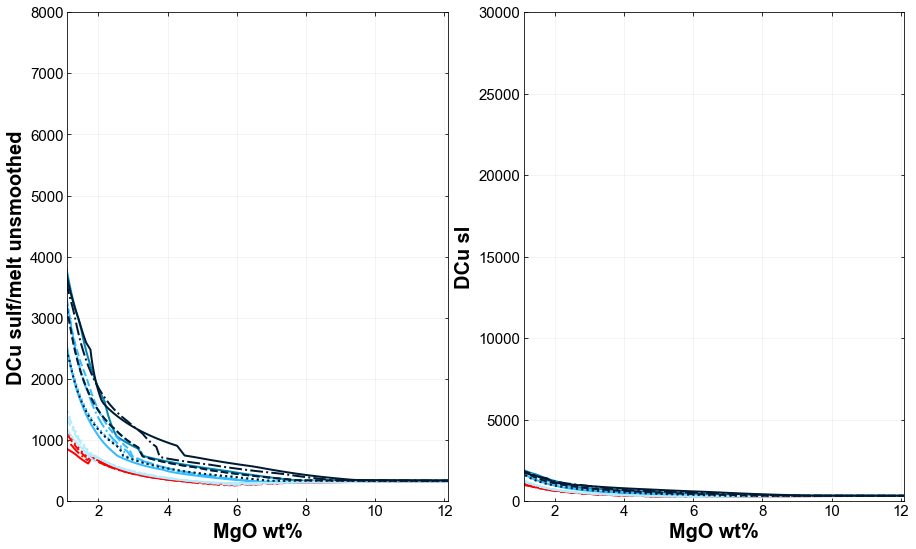

In [32]:
# optional plotting to compare differences in DX_sl versus DX_sulf/sil

from matplotlib.cm import viridis, cividis
from cmcrameri import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

om_dict = {'H2O_0.1_QFM1.2':'#b3ecff','H2O_1.0_QFM1.2': '#33bbff', 'H2O_3.0_QFM1.2':'#0086b3', 'H2O_6.0_QFM1.2':'#001a33','H2O_0.0_QFM1.2':'red'}

pressure = syst_mass['pressure_bar'].unique()
lines = ['solid','solid','solid', 'dashdot', 'dashed', 'dotted']
#lines = ['solid', 'dashdot', 'dashed', 'dotted']
pdict = dict(zip(pressure, lines))

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 2, figsize=(15, 9))


for v in syst_mass.newcolumn.unique():
    df_v = syst_mass[syst_mass.newcolumn == v]
    for p in [4000, 2000, 1000,500]:
        df_vp = df_v[df_v.pressure_bar == p]
        y = df_vp['DCu_sulfsil']
        x = df_vp['MgO_Liq']
        
        ax[0].plot(x, y, color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)
        ax[1].plot(x, df_vp['DCu_sl'],color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)

ax = ax.flatten()
for i in range(2):

    ax[i].tick_params(axis='both', which='both',top=True,right=True, labelsize=12, direction='in')
    ax[i].set_xlim(1.1,12.1)
    ax[i].grid(color='grey',which='both', alpha=0.1, zorder=0)
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in', top=True,right=True)
    ax[i].set_xlabel('MgO wt%', fontsize=20,weight='bold')
    if i == 0:
        ax[i].set_ylabel('DCu sulf/melt unsmoothed', fontsize=20, weight='bold')
        ax[i].set_ylim(0,8000)
        
    if i == 1:
        ax[i].set_ylabel('DCu sl', fontsize=20, weight='bold')
        ax[i].set_ylim(0,30000)

In [33]:
kd_comp = syst_mass[['T_C', 'SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'Cr2O3_Liq',
       'Fe2O3_Liq', 'FeO_Liq', 'FeOt_Liq', 'MnO_Liq', 'MgO_Liq', 'CaO_Liq',
       'Na2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'CO2_Liq', 'Fe3Fet_Liq',
       'h_Liq', 'mass_Liq', 'v_Liq', 'rho_Liq', 'pressure_bar', 'newcolumn',
       'index','G','DCu_fm','DRe_fm', 'DSe_fm', 'DTe_fm', 'DAg_fm','DAu_fm',
         'DCl_fm','DS_fm','NaCl_fluid']] 

kd_comp_sl = syst_mass[['T_C', 'SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'Cr2O3_Liq',
       'Fe2O3_Liq', 'FeO_Liq', 'FeOt_Liq', 'MnO_Liq', 'MgO_Liq', 'CaO_Liq',
       'Na2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'CO2_Liq', 'Fe3Fet_Liq',
       'h_Liq', 'mass_Liq', 'v_Liq', 'rho_Liq', 'pressure_bar', 'newcolumn',
       'index','G','DCu_sl','DAg_sl','DAu_sl','DCu_mss','DAg_mss','DAu_mss','DSe_mss', 
               'DRe_sl', 'DSe_sl','DRe_sl', 'DTe_sl', 'DRe_mss','DTe_mss',
                       'DCu_sulfsil','DAg_sulfsil','DAu_sulfsil','DSe_sulfsil','DRe_sulfsil',
                       ]]
kd_comp_sl.columns[25:]

Index(['DCu_sl', 'DAg_sl', 'DAu_sl', 'DCu_mss', 'DAg_mss', 'DAu_mss',
       'DSe_mss', 'DRe_sl', 'DSe_sl', 'DRe_sl', 'DTe_sl', 'DRe_mss', 'DTe_mss',
       'DCu_sulfsil', 'DAg_sulfsil', 'DAu_sulfsil', 'DSe_sulfsil',
       'DRe_sulfsil'],
      dtype='object')

In [34]:
kd_piv = pd.melt(kd_comp, id_vars=kd_comp.columns[:24], value_vars =kd_comp.columns[24:]).rename(columns = {'variable': 'Kd', 'value': 'value'}, inplace = False)
kd_piv = kd_piv.dropna(subset=['value'])

kd_piv_sl = pd.melt(kd_comp_sl, id_vars=kd_comp_sl.columns[:25], value_vars =kd_comp_sl.columns[25:]).rename(columns = {'variable': 'Kd', 'value': 'value'}, inplace = False)
kd_piv_sl = kd_piv_sl.dropna(subset=['value'])

sliced = kd_piv[kd_piv.pressure_bar.isin([4000])]
sliced_dp = kd_piv[kd_piv.pressure_bar.isin([1000])]

sliced_sl = kd_piv_sl[kd_piv_sl.pressure_bar.isin([4000])]
sliced_sl_dp = kd_piv_sl[kd_piv_sl.pressure_bar.isin([1000])]

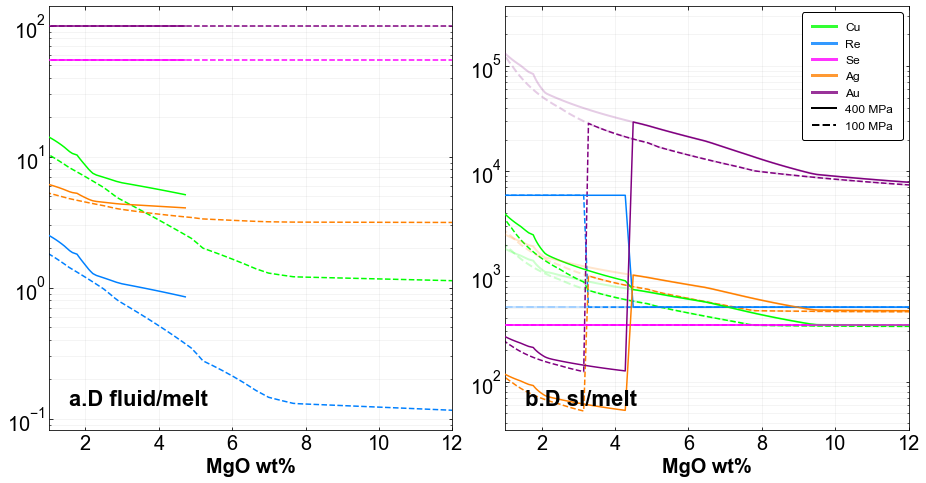

In [35]:
# Plotting the relative volatility and sulfide affinity of the chalcophile elements modelled:

fig = plt.figure(figsize=(13,7)) 
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
plt.rcParams["font.family"] ="Arial" 

subcat_sl = ['DRe_sulfsil','DCu_sulfsil','DSe_sulfsil', 'DAg_sulfsil','DAu_sulfsil']
#subcat_sl = ['DRe_sl','DCu_sl','DSe_sl', 'DAg_sl','DAu_sl']
subcat_fm = ['DRe_fm','DCu_fm','DSe_fm', 'DAg_fm','DAu_fm']

subsubcat = ['H2O_6.0_QFM1.2'] 

subdict =  {'DCu_fm': (0.0, 1.0, 0.0),
           'DTe_fm': '#00264d',
 'DSe_fm': (1.0, 0.0, 1.0),
 'DRe_fm': (0.0, 0.5, 1.0),
 'DAg_fm': (1.0, 0.5, 0.0),
 'DAu_fm': (0.5, 0.0, 0.5),
           'DCl_fm': 'red',
           'DS_fm': 'blue'} 

# choose what you would like to project
subdict_sl = {'DCu_sulfsil': (0.0, 1.0, 0.0),'DSe_sulfsil': (1.0, 0.0, 1.0),'DRe_sulfsil': (0.0, 0.5, 1.0),'DAg_sulfsil': (1.0, 0.5, 0.0),'DAu_sulfsil': (0.5, 0.0, 0.5)}
#subdict_sl = {'DCu_sl': (0.0, 1.0, 0.0),'DSe_sl': (1.0, 0.0, 1.0),'DRe_sl': (0.0, 0.5, 1.0),'DAg_sl': (1.0, 0.5, 0.0),'DAu_sl': (0.5, 0.0, 0.5)}



linedict = dict(zip(subsubcat, ['solid', 'dashdot', 'dashed','dotted', 'solid']))
for i in subcat_fm:
        dfh = sliced_dp[sliced_dp['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            fin['value'] = fin['value'].replace(0, np.nan)
            x = fin['MgO_Liq']
            y = fin['value']
            ax[0].plot(x,y, color=subdict[i], linestyle='--', label=i, alpha=1)
            
for i in subcat_sl:
        dfh = sliced_sl_dp[sliced_sl_dp['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            x = fin['MgO_Liq']
            y = fin['value']
            ax[1].plot(x,y, color=subdict_sl[i], linestyle='--', label=i, alpha=1)

for i in subcat_fm:
        dfh = sliced[sliced['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            fin['value'] = fin['value'].replace(0, np.nan)
            x = fin['MgO_Liq']
            y = fin['value']
            ax[0].plot(x,y, color=subdict[i], linestyle='-', label=i, alpha=1,zorder=3)
            
for i in subcat_sl:
        dfh = sliced_sl[sliced_sl['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            x = fin['MgO_Liq']
            y = fin['value']
            ax[1].plot(x,y, color=subdict_sl[i], linestyle='-', label=i, alpha=1, zorder=3)
            
            

            
##### overlay SL only data:
subcat_sl = ['DRe_sl','DCu_sl','DSe_sl', 'DAg_sl','DAu_sl']
subdict_sl = {'DCu_sl': (0.0, 1.0, 0.0),'DSe_sl': (1.0, 0.0, 1.0),'DRe_sl': (0.0, 0.5, 1.0),'DAg_sl': (1.0, 0.5, 0.0),'DAu_sl': (0.5, 0.0, 0.5)}
for i in subcat_sl:
        dfh = sliced_sl_dp[sliced_sl_dp['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            x = fin['MgO_Liq']
            y = fin['value']
            ax[1].plot(x,y, color=subdict_sl[i], linestyle='--', linewidth=2,label=i, alpha=0.2)
for i in subcat_sl:
        dfh = sliced_sl[sliced_sl['Kd'] == i]
        
        for j in subsubcat:
            fin = dfh[dfh.newcolumn == j]
            x = fin['MgO_Liq']
            y = fin['value']
            ax[1].plot(x,y, color=subdict_sl[i], linestyle='-',linewidth=2, label=i, alpha=0.2, zorder=3)

            
            
for i in range(2):
    ax[i].set_xlabel('MgO wt%',fontsize=20,weight='bold' )
    
    ax[i].grid(color='grey',which='both', alpha=0.1, zorder=0)
    ax[i].set_xlim(1,12)
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='both', labelsize=20, direction='in', top=True,right=True)
    ax[1].set_yticks([100, 1000,10000,1e5])#,1e5, 1e6])
    ax[0].set_yticks([0.1, 1, 10, 100])

        
# Legend plotting
from matplotlib.lines import Line2D
color =list(subdict.values())
line_pressure = [Line2D([0], [0], color=color[0],lw=3, linestyle='-',alpha=0.8),
                Line2D([0], [0], color=color[3],lw=3,  linestyle='-',alpha=0.8),
                Line2D([0], [0], color=color[2],lw=3,  linestyle='-',alpha=0.8),
               
                 Line2D([0], [0], color=color[4],lw=3, linestyle='-',alpha=0.8),
                 Line2D([0], [0], color=color[5],lw=3, linestyle='-',alpha=0.8),
            
                 Line2D([0], [0], color='k',lw=2,),
                 Line2D([0], [0], color='k',lw=2,linestyle='--')]

ax[1].legend(line_pressure,['Cu','Re','Se','Ag','Au' ,'400 MPa','100 MPa'],  fontsize=12,
                 frameon=True,edgecolor='k', borderpad=0.8, ncol=1,loc = 'upper right',framealpha=1)

#ax[0].annotate(r'e.g. for $H_{2}O$ 6.0 wt%', xy=(0.55, 0.72), fontsize=15, xycoords='axes fraction', color='black', zorder=5)
ax[0].annotate('a.D fluid/melt', xy=(0.05, 0.06), fontsize=22, xycoords='axes fraction', color='black', weight='bold',zorder=5)
ax[1].annotate('b.D sl/melt', xy=(0.05, 0.06), fontsize=22, xycoords='axes fraction', color='black', weight='bold',zorder=5)
plt.tight_layout()


# Modelling sulfide saturation 

Here we calculate the mass and concentration of sulfide and sulphate forming and the corresponding mass and concentration of S and chaclophile elements within the sulfide liquid, melt and fluid phases. 

We perform iterative calcualtions that evaluate whether the melt is still sulfide saturated at each step. 

without this re-equilibration step, the mass fraction of fluid is over-estimated and sulfide under-estimated. 

In [36]:
# iterated output should have the same shape as original dataframe
syst_mass.shape

(2660, 492)

In [37]:
dfnew = syst_mass.copy()

In [38]:
# Check that our penultimate column has non NaN values - this is important - if no fluid then should be 0.0
# for the iteration loop below.  
for u in dfnew.unique.unique():
    syst_mass = dfnew[dfnew['unique'].isin([u])].copy()
    print(f"Penultimate row of DataFrame {u}:\n", syst_mass['S_D/G'].iloc[-2])

Penultimate row of DataFrame P_10000.0_H2O_0.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_10000.0_H2O_3.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_10000.0_H2O_1.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_10000.0_H2O_0.1_QFM1.2:
 0.0
Penultimate row of DataFrame P_10000.0_H2O_6.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_8000.0_H2O_0.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_8000.0_H2O_3.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_8000.0_H2O_0.1_QFM1.2:
 0.0
Penultimate row of DataFrame P_8000.0_H2O_1.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_8000.0_H2O_6.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_4000.0_H2O_0.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_4000.0_H2O_3.0_QFM1.2:
 0.0250662215650469
Penultimate row of DataFrame P_4000.0_H2O_1.0_QFM1.2:
 0.0
Penultimate row of DataFrame P_4000.0_H2O_0.1_QFM1.2:
 0.0
Penultimate row of DataFrame P_4000.0_H2O_6.0_QFM1.2:
 1.0944649290910085
Penultimate row of DataFrame P_2000.0_H2O_0.0_QFM1.2:
 0.0
Penultimate row of Da

In [39]:
warnings.filterwarnings('ignore', category=pd.core.generic.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Define columns to be filled in this loop and changed
dfnew[['melt_S2_ppm', 'satmelt_S2_ppm', 'melt_S6_ppm', 'GG', 'S_sulfide_ppm', 'M_S_sulfide','DS_sulfsil', 'DS_sl', 'DS_mss',
           'M_S_sulf_cumu', 'melt_Stot_ppm', 'M_satmelt_S', 'sulfide_Cu_ppm']] = 0.0

# Change depending on model requirements
eqbm_dict = {'S': 1000, 'Cu': 75,'Ag':0.03,'Au':0.0033,'Se':0.14,'Re':0.001}
#metal_sulfide_dict = {'Cu':'DCu_mss','Re':'DRe_mss','Se':'DSe_mss','Te':'DTe_mss', 'Ag':'DAg_mss', 'Au':'DAu_mss'}
metal_sulfide_dict = {'Cu':'DCu_sulfsil','Re':'DRe_sulfsil','Se':'DSe_sulfsil','Ag':'DAg_sulfsil', 'Au':'DAu_sulfsil'}
#metal_sulfide_dict = {'Cu':'DCu_sl','Re':'DRe_sl','Se':'DSe_sl','Ag':'DAg_sl', 'Au':'DAu_sl'}


# Create an empty dictionary to store DataFrames
result_dataframes = {}

max_iterations = 100  # Set the desired number of iterations

for u in dfnew.unique.unique():
    syst_mass = dfnew[dfnew['unique'].isin([u])].copy()
    
    # Initialize a counter for testing
    iteration_counter = 0
    condition_met = True
    
    while condition_met: 

        if iteration_counter == 0:
            syst_mass['melt_S2_ppm'] = syst_mass['melt_S_ppm'] * (1 - syst_mass['jugo_s6st'])
        else:
            syst_mass['melt_S2_ppm'] = syst_mass['new_Cmelt_S2']
        # Calculate S_sulfide_ppm and satmelt_S2_ppm
        syst_mass['S_sulfide_ppm'] = syst_mass['melt_S2_ppm'].sub(syst_mass['SCSS_OM21']).clip(0)
        syst_mass['satmelt_S2_ppm'] = syst_mass['melt_S2_ppm'].sub(syst_mass['S_sulfide_ppm'])

        # Calculate M_S_sulfide and M_S_sulf_cumu
        syst_mass['M_S_sulfide'] = (syst_mass['mass_Liq'] + syst_mass['fluid_cum_sum_H2O']) * syst_mass['S_sulfide_ppm'] / 10 ** 6
        
        syst_mass['M_S_sulf_cumu'] += syst_mass['M_S_sulfide']

        # Calculate melt_S6_ppm
        syst_mass['melt_S6_ppm'] = syst_mass['melt_S_ppm'] * syst_mass['jugo_s6st']
        syst_mass['melt_S6_ppm'] = syst_mass['melt_S6_ppm'].where(syst_mass['melt_S6_ppm'] < syst_mass['SCAS'], syst_mass['SCAS'])

        # Calculate melt_Stot_ppm and M_satmelt_S
        syst_mass['melt_Stot_ppm'] = syst_mass['melt_S6_ppm'] + syst_mass['satmelt_S2_ppm']
        syst_mass['M_satmelt_S'] = syst_mass['melt_Stot_ppm'] * (syst_mass['mass_Liq'] / 10 ** 6)

        # Calculate DS_sulfsil or DS_sl or DS_mss - depends on what you would like to model
        syst_mass['DS_sulfsil'] = 50 / (syst_mass['melt_Stot_ppm'] / 10000)
        

        # Calculate GG
        syst_mass['GG'] = syst_mass['mass_Liq'] / (2 * syst_mass['M_S_sulfide']).where(syst_mass['M_S_sulfide'] > 0, 0)

        # Calculate metal_sulfide_dict
        for key, val in metal_sulfide_dict.items():
            syst_mass[key + '_D/GG'] = syst_mass[val] / syst_mass['GG'].where(syst_mass['GG'] > 0, 1)

            syst_mass['totM_' + key + '_sulfide+melt'] = ((2 * syst_mass['M_S_sulfide']) + syst_mass['mass_Liq']) * syst_mass['melt_' + key + '_ppm'] / 10**6
            syst_mass['M_' + key + '_sulfide'] = syst_mass['totM_' + key + '_sulfide+melt'] * syst_mass[key + '_D/GG'] / (syst_mass[key + '_D/GG'] + 1)
            syst_mass['M_melt_' + key + '_final'] = syst_mass['totM_' + key + '_sulfide+melt'] - syst_mass['M_' + key + '_sulfide']

            # concentration (ppm) of chalcophile element in melt after sulfide phase and fluids formed
            syst_mass['melt_'+key+'_ppm_final'] = 1000000 * syst_mass['M_melt_'+key+'_final'].div(syst_mass['mass_Liq'])

            syst_mass['sulfide_' + key + '_ppm'] = 1000000 * syst_mass['M_' + key + '_sulfide'] / (2 * syst_mass['M_S_sulfide']).where(syst_mass['M_' + key + '_sulfide'] > 0, 0)


        # equilibration steps
        # calcualting the mass fraction of fluid (Xfluid), sulfide (Xsulf), melt (Xmelt) and solids (Xsolid) in the system 
        syst_mass['Xfluid'] = syst_mass['fluid_cum_sum_H2O'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xsulf'] = (2*syst_mass['M_S_sulf_cumu']).div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xmelt'] = syst_mass['mass_Liq'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xsolid'] = syst_mass['M_solid'].div(syst_mass['i_M_fluid']+syst_mass['i_M_melt']+syst_mass['i_M_solid'])

        syst_mass['Xtotal'] = syst_mass['Xfluid'] + syst_mass['Xsulf'] + syst_mass['Xmelt'] + syst_mass['Xsolid']

        syst_mass['Xfluid_norm'] = syst_mass['Xfluid'] / syst_mass['Xtotal']

        syst_mass['Xsulf_norm'] = syst_mass['Xsulf'] / syst_mass['Xtotal']

        syst_mass['Xmelt_norm'] = syst_mass['Xmelt'] / syst_mass['Xtotal']

        syst_mass['Xsolid_norm'] = syst_mass['Xsolid'] / syst_mass['Xtotal']

        syst_mass['Xtotal_norm'] = syst_mass['Xtotal'] / syst_mass['Xtotal']

        for key, val in eqbm_dict.items():
            # CiXi is the total system mass of a given element
            syst_mass['CiXi_' + key] = (val / 10000) * syst_mass['Xtotal_norm']
            
            # equilibrated concentration of element in melt, wt%
            # change 'D'+key+'_sl' term to 'D'+key+'_mss' or 'D'+key+'_sulfsil' if desired
            syst_mass['new_Cmelt_' + key] = syst_mass['CiXi_' + key] / (syst_mass['Xmelt_norm'] + (syst_mass['Xfluid_norm'] * syst_mass['D' +key+'_fm']) + (syst_mass['Xsulf_norm'] * syst_mass['D'+key+'_sulfsil']))
            # equilibrated concentration of element in fluid, wt%
            syst_mass['new_Cfluid_' + key] = np.where(syst_mass['Xfluid_norm'] == 0, 0,syst_mass['D'+key+'_fm'] * syst_mass['new_Cmelt_' + key])
            # equilibrated concentration of element in sulfide, wt%
            # change 'D'+key+'_sl' term to 'D'+key+'_mss' or 'D'+key+'_sulfsil' if desired
            syst_mass['new_Csulf_' + key] = np.where(syst_mass['Xsulf_norm'] == 0, 0,syst_mass['D'+key+'_sulfsil'] * syst_mass['new_Cmelt_' + key])
            # equilibrated mass of element in melt, g
            syst_mass['new_Mmelt_'+key] = syst_mass['new_Cmelt_'+key] * syst_mass['Xmelt_norm']
            # equilibrated mass of element in fluid, g
            syst_mass['new_Mfluid_'+key] = syst_mass['new_Cfluid_'+key] *syst_mass['Xfluid_norm']
            # equilibrated mass of element in sulfide, g
            syst_mass['new_Msulf_'+key] = syst_mass['new_Csulf_'+key] *syst_mass['Xsulf_norm']
            # check mass balance is adhered to
            syst_mass['new_tot_mass_check_'+key] = syst_mass['new_Mmelt_'+key] + syst_mass['new_Mfluid_'+key] + syst_mass['new_Msulf_'+key]
            # new melt concentration of S2-, after we have equilibrated
            syst_mass['new_Cmelt_S2'] = 10**4 * syst_mass['new_Cmelt_S'] * (1 - syst_mass['jugo_s6st'])
            # check that condition is met
            syst_mass['condition_check'] = syst_mass['new_Cmelt_S2'] / syst_mass['SCSS_OM21']

        print(f"Iteration {iteration_counter} condition value:", syst_mass['new_Cmelt_S2'].iloc[-2]/(syst_mass['SCSS_OM21'].iloc[-2]))

        # Check if the last value is within 1% of SCSS
        if syst_mass['new_Cmelt_S2'].iloc[-2]/syst_mass['SCSS_OM21'].iloc[-2] < 1.001:
            print("Breaking the loop due to the last value being within 1% of SCSS")
            break

        # Check the condition for the while loop
        condition_met = iteration_counter < max_iterations
        iteration_counter += 1
    
    
    # Store resulting df in the dictionary
    result_dataframes[u] = syst_mass.copy()
    
# Print the number of iterations completed for each dataframe
for key, df in result_dataframes.items():
    print(f"Number of iterations completed for DataFrame {key}: {df.shape[0]}")
# Display the tail of the DataFrame
#syst_mass.tail()


Iteration 0 condition value: 1.7261097087384392
Iteration 1 condition value: 1.693873122213425
Iteration 2 condition value: 1.66417374172107
Iteration 3 condition value: 1.6367055928697893
Iteration 4 condition value: 1.6112119768740303
Iteration 5 condition value: 1.5874757009017069
Iteration 6 condition value: 1.5653115794406482
Iteration 7 condition value: 1.5445606072731133
Iteration 8 condition value: 1.525085380277739
Iteration 9 condition value: 1.5067664597226502
Iteration 10 condition value: 1.489499458349241
Iteration 11 condition value: 1.473192684617891
Iteration 12 condition value: 1.4577652228860636
Iteration 13 condition value: 1.4431453571950499
Iteration 14 condition value: 1.4292692682101469
Iteration 15 condition value: 1.4160799490321183
Iteration 16 condition value: 1.4035262976851604
Iteration 17 condition value: 1.391562353209266
Iteration 18 condition value: 1.380146649233313
Iteration 19 condition value: 1.36924166424309
Iteration 20 condition value: 1.35881335

Iteration 1 condition value: 1.7425950302063493
Iteration 2 condition value: 1.6384843514933811
Iteration 3 condition value: 1.5584342720565858
Iteration 4 condition value: 1.49457296319184
Iteration 5 condition value: 1.4422339837124474
Iteration 6 condition value: 1.3984455585175983
Iteration 7 condition value: 1.3612105606333509
Iteration 8 condition value: 1.329129302646502
Iteration 9 condition value: 1.301187135797312
Iteration 10 condition value: 1.2766278243890867
Iteration 11 condition value: 1.2548744709046868
Iteration 12 condition value: 1.2354781958423198
Iteration 13 condition value: 1.2180837289132298
Iteration 14 condition value: 1.202405686796441
Iteration 15 condition value: 1.1882118185659962
Iteration 16 condition value: 1.1753109193195854
Iteration 17 condition value: 1.1635439469642255
Iteration 18 condition value: 1.1527773838271063
Iteration 19 condition value: 1.1428982013948605
Iteration 20 condition value: 1.1338099894384206
Iteration 21 condition value: 1.12

Iteration 3 condition value: 1.1263502830331293
Iteration 4 condition value: 1.0988322980520855
Iteration 5 condition value: 1.0782283336288896
Iteration 6 condition value: 1.0624603191744115
Iteration 7 condition value: 1.0501983110712423
Iteration 8 condition value: 1.040547081973103
Iteration 9 condition value: 1.0328801545197763
Iteration 10 condition value: 1.0267455258991325
Iteration 11 condition value: 1.0218090326516154
Iteration 12 condition value: 1.0178187297014418
Iteration 13 condition value: 1.014581608811496
Iteration 14 condition value: 1.011947876586533
Iteration 15 condition value: 1.009800034928404
Iteration 16 condition value: 1.0080451102090688
Iteration 17 condition value: 1.0066090050157743
Iteration 18 condition value: 1.0054323164542662
Iteration 19 condition value: 1.0044671903159519
Iteration 20 condition value: 1.003674921484425
Iteration 21 condition value: 1.0030241015280115
Iteration 22 condition value: 1.002489173915847
Iteration 23 condition value: 1.0

Iteration 43 condition value: 1.0261706895176148
Iteration 44 condition value: 1.0246021314000386
Iteration 45 condition value: 1.023131958960099
Iteration 46 condition value: 1.0217534899814298
Iteration 47 condition value: 1.0204605559308217
Iteration 48 condition value: 1.0192474555341517
Iteration 49 condition value: 1.018108913336836
Iteration 50 condition value: 1.0170400426241426
Iteration 51 condition value: 1.0160363121656757
Iteration 52 condition value: 1.0150935163231942
Iteration 53 condition value: 1.014207748124159
Iteration 54 condition value: 1.0133753749569567
Iteration 55 condition value: 1.0125930165892858
Iteration 56 condition value: 1.0118575252499953
Iteration 57 condition value: 1.011165967547844
Iteration 58 condition value: 1.010515608029108
Iteration 59 condition value: 1.009903894200416
Iteration 60 condition value: 1.0093284428642764
Iteration 61 condition value: 1.008787027632974
Iteration 62 condition value: 1.0082775675023035
Iteration 63 condition valu

Iteration 19 condition value: 1.201034415113248
Iteration 20 condition value: 1.1895494509129365
Iteration 21 condition value: 1.178920160941755
Iteration 22 condition value: 1.1690598826356515
Iteration 23 condition value: 1.1598934906946634
Iteration 24 condition value: 1.1513554958242789
Iteration 25 condition value: 1.143388513163876
Iteration 26 condition value: 1.1359420182966853
Iteration 27 condition value: 1.1289713290952668
Iteration 28 condition value: 1.1224367664736679
Iteration 29 condition value: 1.1163029580272479
Iteration 30 condition value: 1.11053825666126
Iteration 31 condition value: 1.105114252414121
Iteration 32 condition value: 1.100005360314302
Iteration 33 condition value: 1.0951884706568251
Iteration 34 condition value: 1.0906426508233993
Iteration 35 condition value: 1.0863488899002591
Iteration 36 condition value: 1.0822898790168554
Iteration 37 condition value: 1.0784498216454765
Iteration 38 condition value: 1.0748142691477265
Iteration 39 condition valu

Iteration 47 condition value: 1.150101180716077
Iteration 48 condition value: 1.145909404197564
Iteration 49 condition value: 1.141863905359411
Iteration 50 condition value: 1.1379578966705632
Iteration 51 condition value: 1.1341850070808344
Iteration 52 condition value: 1.1305392498310705
Iteration 53 condition value: 1.1270149932524174
Iteration 54 condition value: 1.1236069342321977
Iteration 55 condition value: 1.1203100740633798
Iteration 56 condition value: 1.1171196964287238
Iteration 57 condition value: 1.1140313473002141
Iteration 58 condition value: 1.1110408165599799
Iteration 59 condition value: 1.1081441211711966
Iteration 60 condition value: 1.1053374897468635
Iteration 61 condition value: 1.1026173483813217
Iteration 62 condition value: 1.0999803076242296
Iteration 63 condition value: 1.097423150489732
Iteration 64 condition value: 1.0949428214050096
Iteration 65 condition value: 1.0925364160124926
Iteration 66 condition value: 1.0902011717489084
Iteration 67 condition v

Iteration 20 condition value: 1.2099915329123119
Iteration 21 condition value: 1.1982526324858362
Iteration 22 condition value: 1.1873772901803077
Iteration 23 condition value: 1.177278620435243
Iteration 24 condition value: 1.1678812505878844
Iteration 25 condition value: 1.159119431960549
Iteration 26 condition value: 1.1509355166684896
Iteration 27 condition value: 1.1432787192575191
Iteration 28 condition value: 1.1361041022594016
Iteration 29 condition value: 1.1293717393139733
Iteration 30 condition value: 1.1230460202423247
Iteration 31 condition value: 1.117095070455596
Iteration 32 condition value: 1.1114902631055164
Iteration 33 condition value: 1.1062058069576466
Iteration 34 condition value: 1.101218396474275
Iteration 35 condition value: 1.096506913302898
Iteration 36 condition value: 1.0920521704754733
Iteration 37 condition value: 1.0878366922778824
Iteration 38 condition value: 1.0838445240552697
Iteration 39 condition value: 1.0800610672570692
Iteration 40 condition va

Iteration 98 condition value: 1.020930230356163
Iteration 99 condition value: 1.0203378308020643
Iteration 100 condition value: 1.0197628570758688
Iteration 0 condition value: 2.366241599049073
Iteration 1 condition value: 2.125703440752184
Iteration 2 condition value: 1.961447204180506
Iteration 3 condition value: 1.84002959379624
Iteration 4 condition value: 1.7456297442001127
Iteration 5 condition value: 1.669607433936464
Iteration 6 condition value: 1.6067730612439628
Iteration 7 condition value: 1.5537893834053151
Iteration 8 condition value: 1.5083966834848888
Iteration 9 condition value: 1.4690016220648858
Iteration 10 condition value: 1.4344433981687421
Iteration 11 condition value: 1.403853213076443
Iteration 12 condition value: 1.3765659208560654
Iteration 13 condition value: 1.3520623654281347
Iteration 14 condition value: 1.3299305323842736
Iteration 15 condition value: 1.3098386539074904
Iteration 16 condition value: 1.2915161434442037
Iteration 17 condition value: 1.27473

Iteration 65 condition value: 1.0591525947034524
Iteration 66 condition value: 1.0573896612435139
Iteration 67 condition value: 1.0556848745068839
Iteration 68 condition value: 1.054035981129183
Iteration 69 condition value: 1.0524408354222328
Iteration 70 condition value: 1.050897392983648
Iteration 71 condition value: 1.0494037047646299
Iteration 72 condition value: 1.0479579115575723
Iteration 73 condition value: 1.046558238868783
Iteration 74 condition value: 1.0452029921448625
Iteration 75 condition value: 1.0438905523242288
Iteration 76 condition value: 1.0426193716878864
Iteration 77 condition value: 1.041387969985887
Iteration 78 condition value: 1.040194930818049
Iteration 79 condition value: 1.0390388982493994
Iteration 80 condition value: 1.0379185736425087
Iteration 81 condition value: 1.0368327126904422
Iteration 82 condition value: 1.0357801226354384
Iteration 83 condition value: 1.034759659659684
Iteration 84 condition value: 1.033770226435706
Iteration 85 condition valu

Iteration 33 condition value: 1.114013141774702
Iteration 34 condition value: 1.1092623281852303
Iteration 35 condition value: 1.1047473727378028
Iteration 36 condition value: 1.1004533836595305
Iteration 37 condition value: 1.0963666840313002
Iteration 38 condition value: 1.0924746879168814
Iteration 39 condition value: 1.088765791598079
Iteration 40 condition value: 1.085229277785872
Iteration 41 condition value: 1.0818552310166818
Iteration 42 condition value: 1.0786344627221596
Iteration 43 condition value: 1.0755584446917794
Iteration 44 condition value: 1.0726192498392493
Iteration 45 condition value: 1.069809499343557
Iteration 46 condition value: 1.0671223153692477
Iteration 47 condition value: 1.0645512786828448
Iteration 48 condition value: 1.0620903905770351
Iteration 49 condition value: 1.0597340385943157
Iteration 50 condition value: 1.0574769656097536
Iteration 51 condition value: 1.0553142418903574
Iteration 52 condition value: 1.053241239797919
Iteration 53 condition va

Iteration 5 condition value: 1.6408939916033416
Iteration 6 condition value: 1.591405577303521
Iteration 7 condition value: 1.5483167330377274
Iteration 8 condition value: 1.5104021104077467
Iteration 9 condition value: 1.4767418322382706
Iteration 10 condition value: 1.4466298348638649
Iteration 11 condition value: 1.4195137993636764
Iteration 12 condition value: 1.3949545398056642
Iteration 13 condition value: 1.372597801295276
Iteration 14 condition value: 1.3521542147163979
Iteration 15 condition value: 1.3333847550788953
Iteration 16 condition value: 1.3160899999852562
Iteration 17 condition value: 1.3001020662298202
Iteration 18 condition value: 1.2852784686247283
Iteration 19 condition value: 1.2714973813592367
Iteration 20 condition value: 1.2586539380187092
Iteration 21 condition value: 1.2466573112457056
Iteration 22 condition value: 1.235428384873112
Iteration 23 condition value: 1.2248978814061564
Iteration 24 condition value: 1.215004843120628
Iteration 25 condition value:

Iteration 72 condition value: 1.0028698670509133
Iteration 73 condition value: 1.0027032049222286
Iteration 74 condition value: 1.0025462720891263
Iteration 75 condition value: 1.002398494859214
Iteration 76 condition value: 1.0022593340138306
Iteration 77 condition value: 1.0021282826637918
Iteration 78 condition value: 1.0020048642466217
Iteration 79 condition value: 1.00188863065506
Iteration 80 condition value: 1.0017791604874375
Iteration 81 condition value: 1.001676057411287
Iteration 82 condition value: 1.001578948632235
Iteration 83 condition value: 1.0014874834608538
Iteration 84 condition value: 1.0014013319707078
Iteration 85 condition value: 1.0013201837413654
Iteration 86 condition value: 1.0012437466806066
Iteration 87 condition value: 1.0011717459204892
Iteration 88 condition value: 1.0011039227823502
Iteration 89 condition value: 1.0010400338061554
Iteration 90 condition value: 1.0009798498399651
Breaking the loop due to the last value being within 1% of SCSS
Iteration 

Iteration 52 condition value: 1.048351446697814
Iteration 53 condition value: 1.0464795135994855
Iteration 54 condition value: 1.0446863486275408
Iteration 55 condition value: 1.0429681526210286
Iteration 56 condition value: 1.041321347300266
Iteration 57 condition value: 1.03974255950258
Iteration 58 condition value: 1.0382286067732973
Iteration 59 condition value: 1.0367764841760538
Iteration 60 condition value: 1.0353833522019875
Iteration 61 condition value: 1.0340465256709093
Iteration 62 condition value: 1.032763463529364
Iteration 63 condition value: 1.031531759460863
Iteration 64 condition value: 1.0303491332326762
Iteration 65 condition value: 1.0292134227115843
Iteration 66 condition value: 1.0281225764880488
Iteration 67 condition value: 1.0270746470545145
Iteration 68 condition value: 1.026067784489051
Iteration 69 condition value: 1.0251002306004702
Iteration 70 condition value: 1.0241703134953648
Iteration 71 condition value: 1.0232764425314123
Iteration 72 condition valu

Iteration 28 condition value: 1.1306464184043712
Iteration 29 condition value: 1.124707939230884
Iteration 30 condition value: 1.1190973347150526
Iteration 31 condition value: 1.1137911967540461
Iteration 32 condition value: 1.1087682895605542
Iteration 33 condition value: 1.104009298081929
Iteration 34 condition value: 1.0994966111584987
Iteration 35 condition value: 1.0952141338899843
Iteration 36 condition value: 1.091147124670937
Iteration 37 condition value: 1.087282053151134
Iteration 38 condition value: 1.0836064760176332
Iteration 39 condition value: 1.0801089280143952
Iteration 40 condition value: 1.0767788260382853
Iteration 41 condition value: 1.0736063844963926
Iteration 42 condition value: 1.0705825403941898
Iteration 43 condition value: 1.067698886859135
Iteration 44 condition value: 1.0649476139992629
Iteration 45 condition value: 1.0623214561586731
Iteration 46 condition value: 1.059813644767566
Iteration 47 condition value: 1.0574178660983693
Iteration 48 condition val

Iteration 0 condition value: 0.27965174865910714
Breaking the loop due to the last value being within 1% of SCSS
Number of iterations completed for DataFrame P_10000.0_H2O_0.0_QFM1.2: 71
Number of iterations completed for DataFrame P_10000.0_H2O_3.0_QFM1.2: 101
Number of iterations completed for DataFrame P_10000.0_H2O_1.0_QFM1.2: 116
Number of iterations completed for DataFrame P_10000.0_H2O_0.1_QFM1.2: 125
Number of iterations completed for DataFrame P_10000.0_H2O_6.0_QFM1.2: 91
Number of iterations completed for DataFrame P_8000.0_H2O_0.0_QFM1.2: 69
Number of iterations completed for DataFrame P_8000.0_H2O_3.0_QFM1.2: 99
Number of iterations completed for DataFrame P_8000.0_H2O_0.1_QFM1.2: 102
Number of iterations completed for DataFrame P_8000.0_H2O_1.0_QFM1.2: 109
Number of iterations completed for DataFrame P_8000.0_H2O_6.0_QFM1.2: 89
Number of iterations completed for DataFrame P_4000.0_H2O_0.0_QFM1.2: 67
Number of iterations completed for DataFrame P_4000.0_H2O_3.0_QFM1.2: 91
N

In [40]:
# check that all of our unique identifiers have been returned
result_dataframes.keys()

dict_keys(['P_10000.0_H2O_0.0_QFM1.2', 'P_10000.0_H2O_3.0_QFM1.2', 'P_10000.0_H2O_1.0_QFM1.2', 'P_10000.0_H2O_0.1_QFM1.2', 'P_10000.0_H2O_6.0_QFM1.2', 'P_8000.0_H2O_0.0_QFM1.2', 'P_8000.0_H2O_3.0_QFM1.2', 'P_8000.0_H2O_0.1_QFM1.2', 'P_8000.0_H2O_1.0_QFM1.2', 'P_8000.0_H2O_6.0_QFM1.2', 'P_4000.0_H2O_0.0_QFM1.2', 'P_4000.0_H2O_3.0_QFM1.2', 'P_4000.0_H2O_1.0_QFM1.2', 'P_4000.0_H2O_0.1_QFM1.2', 'P_4000.0_H2O_6.0_QFM1.2', 'P_2000.0_H2O_0.0_QFM1.2', 'P_2000.0_H2O_1.0_QFM1.2', 'P_2000.0_H2O_0.1_QFM1.2', 'P_2000.0_H2O_6.0_QFM1.2', 'P_1000.0_H2O_0.0_QFM1.2', 'P_1000.0_H2O_3.0_QFM1.2', 'P_1000.0_H2O_1.0_QFM1.2', 'P_1000.0_H2O_0.1_QFM1.2', 'P_1000.0_H2O_6.0_QFM1.2', 'P_500.0_H2O_0.0_QFM1.2', 'P_500.0_H2O_0.1_QFM1.2', 'P_500.0_H2O_3.0_QFM1.2', 'P_500.0_H2O_1.0_QFM1.2', 'P_500.0_H2O_6.0_QFM1.2'])

## Compile the contents of result_dataframes dict to one master frame

In [41]:
to_fill = pd.DataFrame() 

for key in result_dataframes:
 
    new = result_dataframes[key]
    
    to_fill = pd.concat([to_fill, new], ignore_index=True)

## Calculating Cu/X ratios in the evolving melt

In [42]:
Cu_ratio = {'Ag':'new_Cmelt_Ag','Au':'new_Cmelt_Au','Se':'new_Cmelt_Se',
           'Re':'new_Cmelt_Re'}

                 
for key,val in Cu_ratio.items():
    # calculating Cu/X ratios of the melt after fluids and sulfide phase have formed
    # where X represents another chalcophile element
    to_fill['Cu/'+key+'_eqbm'] = to_fill['new_Cmelt_Cu'].div(to_fill[val])


In [43]:
to_fill['new_Msulf/Mfluid_Cu'] = to_fill['new_Msulf_Cu']/ to_fill['new_Mfluid_Cu']
to_fill['new_Msulf/Mfluid_S'] = to_fill['new_Msulf_S']/ to_fill['new_Mfluid_S']

## Export completed iterated dataframe

In [44]:
# shape check - row should have same number as prior iteration
to_fill.shape

(2660, 600)

In [45]:
to_fill.unique.unique(), to_fill.shape

to_fill.to_csv('final_model_output.csv')


## Dataframes for experimental data plotted and referred to in Fig S6 and S7

In [ ]:
# Experimental data from Li and Audetat (2015) (LiAud2015) that is most relevant to our modelled FC paths (Fig S7a)

data = {
    'Ex.ID': ['C-1', 'C-7', 'C-11a', 'c12b', 'c13a'],
    'sulfide': ['DSL/SM',  'DMSS/SM', 'DSL/SM', 'MSS/SM', 'MSS/SM'],
    'DCu_sl': [790,  4600, 3800, 990, 13000],
    'DAg_sl': [450,  1600, 1100, 6, 30],
    'DAu_sl': [6100, 20600, 9000, 2000,10],
    'T_C': [1200,  1000, 1100, 900,1000],
    'FeOt_Liq': [8.5,   3.5, 3.5, 1, 3.5],
    'Comp': ['MORB',   'dac', 'dac', 'rhyo', 'dac']
}


liaud = pd.DataFrame(data)
print(liaud)


In [2549]:
# Experimental data from Kiseeva and Wood (2015) (KW2015):

data = {
    "Run No": ["Cu1-1", "Cu2-1", "Cu3-1", "Cu4-1", "Cu5-1", "Cu6-1", "Cu7-1", "Cu8-1", "Cu8-2", "Cu9-1", "Cu10-1", "Cu11-1", "Cu12-1", "KK12-2", "Ni3-1", "Ni5-2", "Ni6-2", "Ni7-1", "KK4-6", "KK4-7", "KK4-8", "KK4-9", "KK4-10", "KK15-6", "KK16-3", "Cu10-2", "Cu11-2", "Cu11-3", "Cu11-5"],
    "DCu_sl": [399, 398, 454, 569, 620, 519, 653, 608, 710, 724, 153, 729, 119, 61, 452, 316, 494, 267, 224, 200, 566, 278, 592, 88, 292, 150, 374, 343, 523],
    "DAg_sl": [364, 357, 395, 465, 507, 438, 507, 470, 537, 557, 186, 843, 167, 88, 660, 369, 436, 273, 234, 238, 633, 358, 649, 121, 388, 173, 467, 370, 616],
    "SiO2": [47.16, 45.44, 45.44, 49.39, 50.01, 48.84, 49.61, 49.34, 48.58, 49.28, 37.6, 45.83, 28.33, 29.54, 44.69, 51.94, 50.94, 46.82, 51.27, 48.72, 48.5, 49.16, 48.07, 38.54, 45.64, 38.5, 44.65, 44.9, 44.73],
    "FeO": [12.55, 13.8, 13.9, 9.24, 7.62, 8.82, 7.85, 8.39, 7.45, 7.2, 27.24, 3.21, 29.88, 37.88, 4.16, 2.33, 5.11, 11.68, 7.13, 8.36, 9.24, 8.74, 9.73, 27.02, 3.01, 26.4, 3.12, 2.83, 3.49],
    "MgO": [9.65, 9.06, 9.04, 10.11, 10.18, 10.4, 10.23, 10.09, 10.04, 10.21, 7.6, 14.92, 7.4, 7.16, 15.77, 10.81, 10.56, 9.64, 10.61, 10.6, 10.05, 10.16, 8.09, 7.98, 16.77, 7.8, 16.75,17.61,16.57]
}

KW2015_exp = pd.DataFrame(data)
KW2015_exp = KW2015_exp[KW2015_exp.FeO>3.5]

In [1882]:
# All experimental data from Li and Audetat (2015) (LiAud2015):

data = {
    'RunNo': ['C-1', 'C-2', 'C-3', 'C-5', 'C-11a', 'C-11b', 'C-6', 'C-7', 'C-12a', 'C-12b', 'C-9a', 'C-9b', 'C-10a', 'C-10b', 'C-13a', 'C-13b'],
    'T_C': [1200, 1200, 1200, 1200, 1100, 1100, 1000, 1000, 900, 900, 1000, 1000, 1000, 1000, 1000, 1000],
    'FeOt_Liq': [8.5, 4.5, 3.5, 1, 3.5, 1, 1, 3.5, 3.5, 1, 3.5, 1, 3.5, 1, 3.5, 1],
    'Sulfide': ['DSL/SM', 'DSL/SM', 'DSL/SM', 'DSL/SM', 'DSL/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM', 'DMSS/SM'],
    'DCu_sl': [790, 1600, 1700, 3100, 3800, 14600, 3400, 740, 5800, 42000, 500, 660, 720, 450, 610, 1100],
    'DAg_sl': [450, 740, 820, 1100, 1100, 500, 99, 29, 56, 440, 13, 10, 22, 12, 8, 11],
    'DAu_sl': [6100, 2000, 10500, 28700, 9000, 350, 510, 410, 380, 2000, 70, 89, 28, 180, 10, 43]
}

liaud_all = pd.DataFrame(data)

In [1883]:
# Experimental data from Kiseeva and Wood (2013) (KW2013):

data = {
    'Run No.': ['KK3-1', 'KK3-2', 'KK4-1', 'KK4-3', 'KK5-1', 'KK5-2', 'KK6-1', 'KK6-3', 'KK7-1', 'KK7-2', 'KK8-1', 'KK8-2', 'KK12-1', 'KK15-1', 'KK15-2', 'KK15-4', 'KK15-5', 'KK16-1', 'KK16-2'],
    'DCu_sl': [542.8, 461, 460.6, 549.6, 471.8, 445.3, 433, 487.3, 496.9, 675.1, 565.3, 636.1, 38.2, 146.4, 162.4, 120.5, 179.1, 396.2, 554.5],
    'DAg_sl': [581.2, 588.6, 552.5, 775.3, 592.7, 574.8, 593.9, 627.1, 668.3, 954.9, 909.6, 857.3, 53.9, 194.5, 266.9, 171.5, 261.9, 569.1, 909],
    'n': [12, 23, 12, 20, 22, 12, 25, 25, 12, 27, 23, 24, 16, 28, 18, 49, 42, 41, 32],
    'SiO2': [50.55, 48.23, 50.3, 48.27, 49.34, 46.52, 47.94, 48.85, 48.05, 46.68, 48.75, 50.7, 30.99, 38.01, 35.68, 37.48, 37.19, 44.75, 45.1],
    'TiO2': [0.82, 0.7, 0.73, 0.73, 0.72, 0.61, 0.7, 0.68, 0.68, 0.64, 0.6, 0.66, 0.47, 0.61, 0.55, 0.58, 0.58, 0, 0],
    'Al2O3': [15.38, 12.75, 13.38, 13.82, 13.52, 15.3, 13.4, 12.88, 12.96, 12.18, 10.03, 12.54, 9.69, 11.99, 10.64, 11.36, 11.25, 17.36, 17.3],
    'FeO': [7.5, 7.98, 7.42, 7.4, 7.15, 6.67, 7.69, 7.73, 8.08, 7.78, 3.4, 3.27, 40.06, 26.07, 25.79, 27.8, 28.78, 3.18, 2.9],
    'MgO': [10.44,16.29,15.56,14.25,15.72,12.79,15.71,17.15,15.89,17.22,22.94,19.75,8.87,7.97,8.36,8.12,8.04,16.99,16.25 ]
}

KW2013_exp = pd.DataFrame(data)

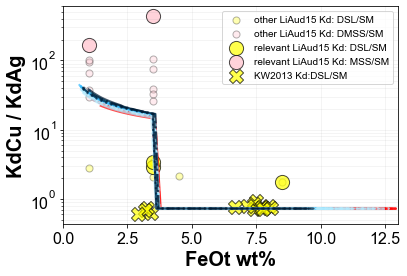

In [1887]:
# all experimental data
liaud_all['KdCu/KdAg'] = liaud_all['DCu_sl'] / liaud_all['DAg_sl']
sulfide_values = liaud_all['Sulfide'].unique()

for sulfide_value in sulfide_values:
    subset_df = liaud_all[liaud_all['Sulfide'] == sulfide_value]
    color = 'yellow' if sulfide_value == 'DSL/SM' else 'pink'  
    plt.scatter(subset_df['FeOt_Liq'], subset_df['KdCu/KdAg'], label=f'other LiAud15 Kd: {sulfide_value}', color=color, alpha=0.3, s=50, edgecolor='k')

# the most relevant to us
sulfide_values = liaud['sulfide'].unique()
liaud['KdCu/KdAg'] = liaud['DCu_sl'] / liaud['DAg_sl']

for sulfide_value in sulfide_values:
    subset_df = liaud[liaud['sulfide'] == sulfide_value]
    color = 'yellow' if sulfide_value == 'DSL/SM' else 'pink'  
    plt.scatter(subset_df['FeOt_Liq'], subset_df['KdCu/KdAg'], label=f'relevant LiAud15 Kd: {sulfide_value}', color=color, alpha=0.7, s=200, edgecolor='k')

    
# Kiseeva    
KW2013_exp['KdCu/KdAg'] = KW2013_exp['DCu_sl'] /  KW2013_exp['DAg_sl'] 
plt.scatter(KW2013_exp['FeO'],KW2013_exp['KdCu/KdAg'], label='KW2013 Kd:DSL/SM', color='yellow',marker='X',alpha=0.7, s=200, edgecolor='k')
    

# Overlay my combined Kd dataset:
for v in to_fill.newcolumn.unique():
    df_v = to_fill[to_fill.newcolumn == v]
    for p in [4000, 2000, 1000,500]:
        df_vp = df_v[df_v.pressure_bar == p]
        x = df_vp['FeOt_Liq']
        y = df_vp['DCu_sulfsil'] / df_vp['DAg_sulfsil']
        
        plt.plot(x, y, color=om_dict[v],linestyle=pdict[p], alpha=0.7, linewidth=2,zorder=2)
        
    
    
# Add labels and legend
plt.xlim(0,13)
#plt.ylim(0.68,0.8)
plt.yscale('log')
plt.xlabel('FeOt wt%', fontsize=20, weight='bold')
plt.ylabel('KdCu / KdAg', fontsize=20, weight='bold')
plt.grid(color='grey', which='both', alpha=0.1, zorder=0)
plt.legend(fontsize=10)

plt.show()

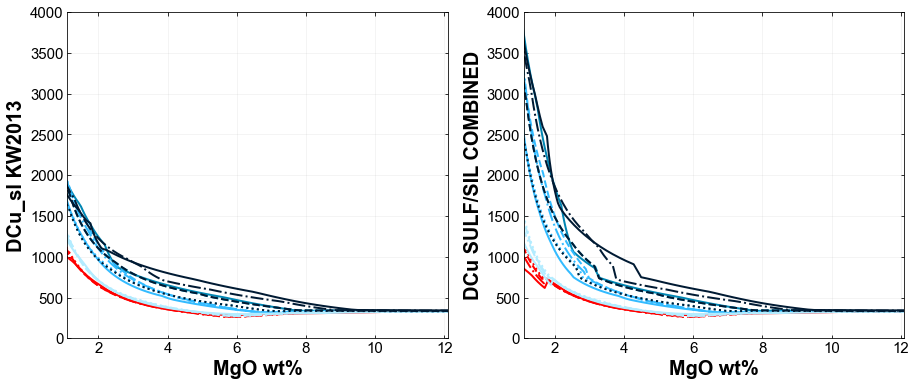

In [1888]:
from matplotlib.cm import viridis, cividis
from cmcrameri import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

om_dict = {'H2O_0.1_QFM1.2':'#b3ecff','H2O_1.0_QFM1.2': '#33bbff', 'H2O_3.0_QFM1.2':'#0086b3', 'H2O_6.0_QFM1.2':'#001a33','H2O_0.0_QFM1.2':'red'}

pressure = to_fill['pressure_bar'].unique()
lines = ['solid','solid','solid', 'dashdot', 'dashed', 'dotted']
#lines = ['solid', 'dashdot', 'dashed', 'dotted']
pdict = dict(zip(pressure, lines))

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 2, figsize=(15, 6))


for v in to_fill.newcolumn.unique():
    df_v = to_fill[to_fill.newcolumn == v]
    for p in [4000, 2000, 1000,500]:
        df_vp = df_v[df_v.pressure_bar == p]
        y = df_vp['DCu_sl']
        x = df_vp['MgO_Liq']
        
        ax[0].plot(x, y, color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)
        ax[1].plot(x, df_vp['DCu_sulfsil'],color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)
        
        
ax = ax.flatten()
for i in range(2):

    ax[i].tick_params(axis='both', which='both',top=True,right=True, labelsize=12, direction='in')
    ax[i].set_xlim(1.1,12.1)
    ax[i].grid(color='grey',which='both', alpha=0.1, zorder=0)
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in', top=True,right=True)
    ax[i].set_xlabel('MgO wt%', fontsize=20,weight='bold')
    if i == 0:
        ax[i].set_ylabel('DCu_sl KW2013', fontsize=20, weight='bold')
        ax[i].set_ylim(0,4000)
        
    if i == 1:
        ax[i].set_ylabel('DCu SULF/SIL COMBINED', fontsize=20, weight='bold')
        ax[i].set_ylim(0,4000)
        


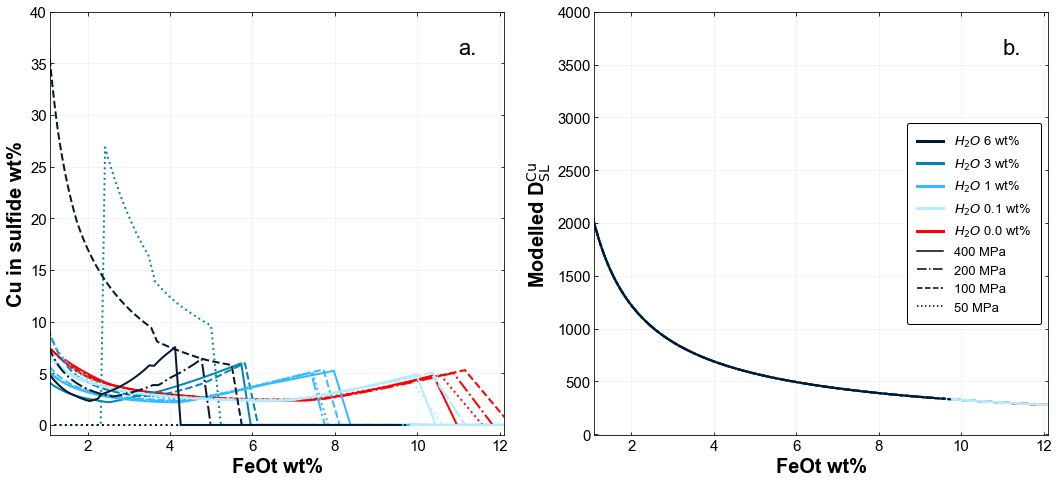

In [1889]:
from matplotlib.cm import viridis, cividis
from cmcrameri import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

om_dict = {'H2O_0.1_QFM1.2':'#b3ecff','H2O_1.0_QFM1.2': '#33bbff', 'H2O_3.0_QFM1.2':'#0086b3', 'H2O_6.0_QFM1.2':'#001a33','H2O_0.0_QFM1.2':'red'}

pressure = to_fill['pressure_bar'].unique()
lines = ['solid','solid','solid', 'dashdot', 'dashed', 'dotted']
#lines = ['solid', 'dashdot', 'dashed', 'dotted']
pdict = dict(zip(pressure, lines))

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

for v in to_fill.newcolumn.unique():
    df_v = to_fill[to_fill.newcolumn == v]
    for p in [4000, 2000, 1000,500]:
        df_vp = df_v[df_v.pressure_bar == p]
        y = df_vp['new_Csulf_Cu']
        x = df_vp['FeOt_Liq']
        
        ax[0].plot(x, y, color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)
        ax[1].plot(x, df_vp['DCu_sl'],color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)

ax = ax.flatten()
for i in range(2):

    ax[i].tick_params(axis='both', which='both',top=True,right=True, labelsize=12, direction='in')
    ax[i].set_xlim(1.1,12.1)
    ax[i].grid(color='grey',which='both', alpha=0.1, zorder=0)
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in', top=True,right=True)
    ax[i].set_xlabel('FeOt wt%', fontsize=20,weight='bold')
    
    if i == 0:
        ax[i].set_ylabel('Cu in sulfide wt%', fontsize=20, weight='bold')
        ax[i].set_ylim(-1,40)
        
    if i == 1:
        ax[i].set_ylabel('Modelled D$^\mathrm{Cu}_\mathrm{SL}$', fontsize=20, weight='bold')
        ax[i].set_ylim(-10,4000)
        
# legend
from matplotlib.lines import Line2D
items = list(pdict.values())
color = list(om_dict.values())
line_pressure = [Line2D([0], [0], color=color[3], lw=3),
                Line2D([0], [0], color=color[2], lw=3),
                Line2D([0], [0], color=color[1], lw=3),
                Line2D([0], [0], color=color[0],lw=3),
                 Line2D([0], [0], color=color[4],lw=3),
                 
               Line2D([0], [0], color='k',linestyle=items[2], lw=1.5),
                Line2D([0], [0], color='k',linestyle=items[3], lw=1.5),
                 Line2D([0], [0], color='k',linestyle=items[4], lw=1.5),
                 Line2D([0], [0], color='k',linestyle=items[5], lw=1.5),] 
ax[1].legend(line_pressure, [ '$H_{2}O$ 6 wt%','$H_{2}O$ 3 wt%', '$H_{2}O$ 1 wt%', '$H_{2}O$ 0.1 wt%','$H_{2}O$ 0.0 wt%',
    '400 MPa','200 MPa',  '100 MPa','50 MPa',], fontsize = 13, 
             frameon=True,edgecolor='k', borderpad=0.8, ncol=1, loc='right', framealpha=1)

import matplotlib.patches as mpatches        
labels = ['a.' , 'b.', ]
for i, label in enumerate(labels):
    ax[i].text(0.9, 0.9, f'{label}', fontsize=22, color='black', zorder=5, transform=ax[i].transAxes)
    
plt.tight_layout()


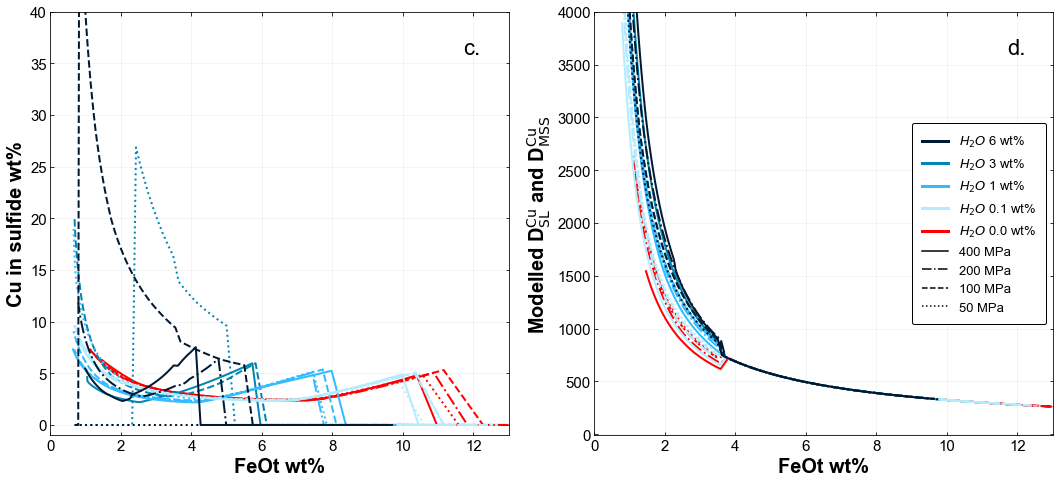

In [1890]:

om_dict = {'H2O_0.1_QFM1.2':'#b3ecff','H2O_1.0_QFM1.2': '#33bbff', 'H2O_3.0_QFM1.2':'#0086b3', 'H2O_6.0_QFM1.2':'#001a33','H2O_0.0_QFM1.2':'red'}

pressure = to_fill['pressure_bar'].unique()
lines = ['solid','solid','solid', 'dashdot', 'dashed', 'dotted']
#lines = ['solid', 'dashdot', 'dashed', 'dotted']
pdict = dict(zip(pressure, lines))

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

for v in to_fill.newcolumn.unique():
    df_v = to_fill[to_fill.newcolumn == v]
    for p in [4000, 2000, 1000,500]:
        df_vp = df_v[df_v.pressure_bar == p]
        y = df_vp['new_Csulf_Cu']
        x = df_vp['FeOt_Liq']
        
        ax[0].plot(x, y, color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)
        ax[1].plot(x, df_vp['DCu_sulfsil'],color=om_dict[v], label=p, linestyle=pdict[p], alpha=1, linewidth=2)

ax = ax.flatten()
for i in range(2):

    ax[i].tick_params(axis='both', which='both',top=True,right=True, labelsize=12, direction='in')
    ax[i].set_xlim(0,13)
    ax[i].grid(color='grey',which='both', alpha=0.1, zorder=0)
    ax[i].tick_params(axis='both', which='both', labelsize=15, direction='in', top=True,right=True)
    ax[i].set_xlabel('FeOt wt%', fontsize=20,weight='bold')
    
    if i == 0:
        ax[i].set_ylabel('Cu in sulfide wt%', fontsize=20, weight='bold')
        ax[i].set_ylim(-1,40)
        
    if i == 1:
        ax[i].set_ylabel('Modelled D$^\mathrm{Cu}_\mathrm{SL}$ and D$^\mathrm{Cu}_\mathrm{MSS}$', fontsize=20, weight='bold')
        ax[i].set_ylim(-10,4000)
        
# legend
from matplotlib.lines import Line2D
items = list(pdict.values())
color = list(om_dict.values())
line_pressure = [Line2D([0], [0], color=color[3], lw=3),
                Line2D([0], [0], color=color[2], lw=3),
                Line2D([0], [0], color=color[1], lw=3),
                Line2D([0], [0], color=color[0],lw=3),
                 Line2D([0], [0], color=color[4],lw=3),
                 
               Line2D([0], [0], color='k',linestyle=items[2], lw=1.5),
                Line2D([0], [0], color='k',linestyle=items[3], lw=1.5),
                 Line2D([0], [0], color='k',linestyle=items[4], lw=1.5),
                 Line2D([0], [0], color='k',linestyle=items[5], lw=1.5),] 
ax[1].legend(line_pressure, [ '$H_{2}O$ 6 wt%','$H_{2}O$ 3 wt%', '$H_{2}O$ 1 wt%', '$H_{2}O$ 0.1 wt%','$H_{2}O$ 0.0 wt%',
    '400 MPa','200 MPa',  '100 MPa','50 MPa',], fontsize = 13, 
             frameon=True,edgecolor='k', borderpad=0.8, ncol=1, loc='right', framealpha=1)

import matplotlib.patches as mpatches        
labels = ['c.' , 'd.', ]
for i, label in enumerate(labels):
    ax[i].text(0.9, 0.9, f'{label}', fontsize=22, color='black', zorder=5, transform=ax[i].transAxes)
    
plt.tight_layout()
